## IMPORTING BERKA SQL DATA INTO CSV FILES FOR EDA AND DATA CLEANING


In [12]:
import mysql.connector
import pandas as pd

# Connection parameters
conn = mysql.connector.connect(
    host="relational.fel.cvut.cz",
    user="guest",
    password="ctu-relational",
    port=3306,
    database="financial"
)

# List of tables to download
tables = ['account', 'card', 'client', 'disp', 'district', 'loan', 'order', 'trans']

# Fetch and save each table
for table in tables:
    df = pd.read_sql(f"SELECT * FROM `{table}`", conn)  # ← Backticks fix SQL reserved words
    df.to_csv(f"{table}.csv", index=False)
    print(f"Saved {table}.csv with {len(df)} records.")

conn.close()

C:\Users\KIIT\AppData\Local\Temp\ipykernel_28192\559861087.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT * FROM `{table}`", conn)  # ← Backticks fix SQL reserved words


Saved account.csv with 4500 records.
Saved card.csv with 892 records.
Saved client.csv with 5369 records.
Saved disp.csv with 5369 records.
Saved district.csv with 77 records.
Saved loan.csv with 682 records.
Saved order.csv with 6471 records.
Saved trans.csv with 1056320 records.


In [14]:
import pandas as pd

# Load CSVs
loan = pd.read_csv("loan.csv")
account = pd.read_csv("account.csv")
disp = pd.read_csv("disp.csv")
client = pd.read_csv("client.csv")
district = pd.read_csv("district.csv")

# Strip whitespace from column names
for df_ in [loan, account, disp, client, district]:
    df_.columns = df_.columns.str.strip()

# Step 1: Merge loan with account
df = loan.merge(account, on='account_id', how='left')

# Step 2: Filter dispositions to owners only and merge client_id
disp_owner = disp[disp['type'] == 'OWNER']
df = df.merge(disp_owner[['account_id', 'client_id']], on='account_id', how='left')

# Step 3: Merge client info (this introduces district_id_x)
df = df.merge(client[['client_id', 'district_id', 'birth_date','gender']], on='client_id', how='left')

# Step 4: Rename district_id columns for clarity
df.rename(columns={'district_id_x': 'district_id_client', 'district_id_y': 'district_id_account'}, inplace=True)

# Step 5: Create district mismatch flag
df['district_mismatch'] = (df['district_id_client'] != df['district_id_account']).astype(int)

# Step 6: Ensure types match for merge
df['district_id_client'] = df['district_id_client'].astype(str)
district['district_id'] = district['district_id'].astype(str)

# Step 7: Merge with district info using client’s district_id
df = df.merge(district, left_on='district_id_client', right_on='district_id', how='left')


## The district_mismatch column is a feature we created to capture a potential geographic inconsistency between where the client lives and where their account was opened which can provide some insight to credit risk.

In [17]:
df.head()


,loan_id,account_id,date_x,amount,duration,payments,status,district_id_client,frequency,date_y,...,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,4959,2,1994-01-05,80952,24,3373.0,A,1,POPLATEK MESICNE,1993-02-26,...,0,1,1,100.0,12541,0.2,0.43,167,85677.0,99107
1,4961,19,1996-04-29,30276,12,2523.0,B,21,POPLATEK MESICNE,1995-04-07,...,7,1,7,67.0,9104,1.5,2.07,123,2299.0,2354
2,4962,25,1997-12-08,30276,12,2523.0,A,68,POPLATEK MESICNE,1996-07-28,...,18,2,6,57.2,9893,4.0,4.72,96,5623.0,5887
3,4967,37,1998-10-14,318480,60,5308.0,D,20,POPLATEK MESICNE,1997-08-18,...,3,1,4,58.4,8547,2.6,3.64,120,1563.0,1542
4,4968,38,1998-04-19,110736,48,2307.0,C,19,POPLATEK TYDNE,1997-08-08,...,3,1,4,52.7,8402,3.1,3.98,120,999.0,1099


In [19]:
df.columns

Index(['loan_id', 'account_id', 'date_x', 'amount', 'duration', 'payments',
       'status', 'district_id_client', 'frequency', 'date_y', 'client_id',
       'district_id_account', 'birth_date', 'gender', 'district_mismatch',
       'district_id', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'A11', 'A12', 'A13', 'A14', 'A15', 'A16'],
      dtype='object')

In [21]:
df1 = df.copy()
df1.info()
df1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_id              682 non-null    int64  
 1   account_id           682 non-null    int64  
 2   date_x               682 non-null    object 
 3   amount               682 non-null    int64  
 4   duration             682 non-null    int64  
 5   payments             682 non-null    float64
 6   status               682 non-null    object 
 7   district_id_client   682 non-null    object 
 8   frequency            682 non-null    object 
 9   date_y               682 non-null    object 
 10  client_id            682 non-null    int64  
 11  district_id_account  682 non-null    int64  
 12  birth_date           682 non-null    object 
 13  gender               682 non-null    object 
 14  district_mismatch    682 non-null    int32  
 15  district_id          682 non-null    obj

,loan_id,account_id,amount,duration,payments,client_id,district_id_account,district_mismatch,A4,A5,...,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
count,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,6.820000e+02,682.000000,...,682.000000,682.000000,682.000000,682.000000,682.000000,674.000000,682.000000,682.000000,674.000000,682.000000
mean,6172.466276,5824.162757,151410.175953,36.492669,4190.664223,7120.573314,38.043988,0.087977,2.720522e+05,39.673021,...,5.648094,1.712610,5.406158,68.212903,9502.986804,2.842136,3.528431,121.218475,14861.621662,16390.818182
std,682.579279,3283.512681,113372.406310,17.075219,2215.830344,4059.120567,25.029929,0.283469,3.583320e+05,33.673348,...,4.588747,1.110404,2.868251,20.245469,1323.150982,1.881095,2.146775,23.366091,27072.441726,31299.743394
min,4959.000000,2.000000,4980.000000,12.000000,304.000000,2.000000,1.000000,0.000000,4.282100e+04,0.000000,...,0.000000,0.000000,1.000000,33.900000,8110.000000,0.200000,0.430000,81.000000,818.000000,888.000000
25%,5577.500000,2967.000000,66732.000000,24.000000,2477.000000,3582.250000,14.000000,0.000000,9.208400e+04,5.000000,...,2.000000,1.000000,4.000000,52.000000,8544.000000,1.500000,1.960000,106.000000,2166.000000,2305.000000
50%,6176.500000,5738.500000,116928.000000,36.000000,3934.000000,6941.000000,40.000000,0.000000,1.246050e+05,35.000000,...,5.000000,1.000000,6.000000,62.100000,8991.000000,2.700000,3.490000,116.000000,3732.500000,3868.000000
75%,6752.500000,8686.000000,210654.000000,48.000000,5813.500000,10711.000000,60.000000,0.000000,2.261220e+05,65.000000,...,8.000000,2.000000,7.000000,87.700000,9897.000000,3.950000,4.790000,132.000000,6949.000000,6872.000000
max,7308.000000,11362.000000,590820.000000,60.000000,9910.000000,13971.000000,77.000000,1.000000,1.204953e+06,151.000000,...,20.000000,5.000000,11.000000,100.000000,12541.000000,7.300000,9.400000,167.000000,85677.000000,99107.000000


In [23]:
from datetime import datetime

# Define a reference date for calculating age
reference_date = datetime(1999, 12, 31)

# Convert birth_date to datetime if not already
df1['birth_date'] = pd.to_datetime(df1['birth_date'], errors='coerce')

# Derive person age in years
df1['person_age'] = df1['birth_date'].apply(lambda x: (reference_date - x).days // 365 if pd.notnull(x) else None)


In [25]:
df1.columns

Index(['loan_id', 'account_id', 'date_x', 'amount', 'duration', 'payments',
       'status', 'district_id_client', 'frequency', 'date_y', 'client_id',
       'district_id_account', 'birth_date', 'gender', 'district_mismatch',
       'district_id', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10',
       'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'person_age'],
      dtype='object')

In [27]:
df1.rename(columns={
    'date_x': 'loan_date',
    'date_y': 'account_open_date'
}, inplace=True)


In [29]:
df1.columns

Index(['loan_id', 'account_id', 'loan_date', 'amount', 'duration', 'payments',
       'status', 'district_id_client', 'frequency', 'account_open_date',
       'client_id', 'district_id_account', 'birth_date', 'gender',
       'district_mismatch', 'district_id', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7',
       'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16',
       'person_age'],
      dtype='object')

In [33]:
df1['loan_date'] = pd.to_datetime(df1['loan_date'], errors='coerce')
df1['account_open_date'] = pd.to_datetime(df1['account_open_date'], errors='coerce')

df1['account_age_days'] = (df1['loan_date'] - df1['account_open_date']).dt.days
df1['account_age_years'] = (df1['account_age_days'] / 365).round(1)


In [35]:
df1.columns

Index(['loan_id', 'account_id', 'loan_date', 'amount', 'duration', 'payments',
       'status', 'district_id_client', 'frequency', 'account_open_date',
       'client_id', 'district_id_account', 'birth_date', 'gender',
       'district_mismatch', 'district_id', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7',
       'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16',
       'person_age', 'account_age_days', 'account_age_years'],
      dtype='object')

In [38]:
import numpy as np 

df1['monthly_burden_ratio'] = df1['payments'] / df1['A11']
df1['loan_amount_to_income_ratio'] = df1['amount'] / df1['A11']

# Replace invalid values (inf or NaN) with 0 or median
for col in ['monthly_burden_ratio', 'loan_amount_to_income_ratio']:
    df1[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    df1[col].fillna(df1[col].median(), inplace=True)


C:\Users\KIIT\AppData\Local\Temp\ipykernel_28192\624155733.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1[col].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\KIIT\AppData\Local\Temp\ipykernel_28192\624155733.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns



In [41]:
df1_good = df1.loc[(df1['status']=='A') | (df1['status']=='C')]
df1_bad = df1.loc[(df1['status']=='B') | (df1['status']=='D')]

## ALL DOCUMENTATION DONE HERE IS DONE ON THE BASIS THAT WHATEVER IS WRITTEN IS MEANT FOR THE PLOT BELOW IT.



## Right-Skewed Distribution:

Most good loans are concentrated in lower amounts.

The highest frequency is around 70,000 to 90,000.

Good borrowers take small loans so that repayment doesnt become a big issue in the future.


<Axes: xlabel='amount', ylabel='Count'>

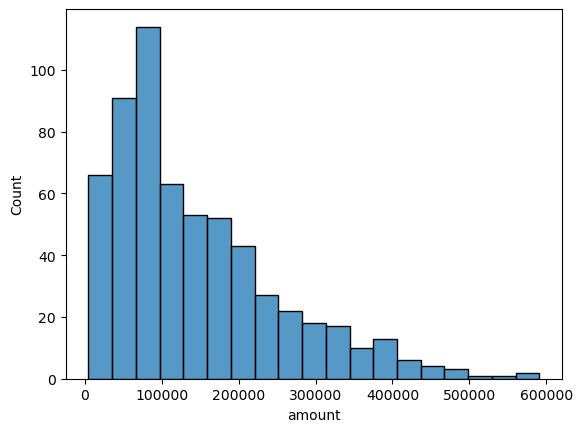

In [46]:
sns.histplot(x = 'amount', data = df1_good)

## ======================================

## Flattened uniform distribution:

Unlike good loans which peak strongly at lower amounts, bad loans are more evenly spread.

<Axes: xlabel='amount', ylabel='Count'>

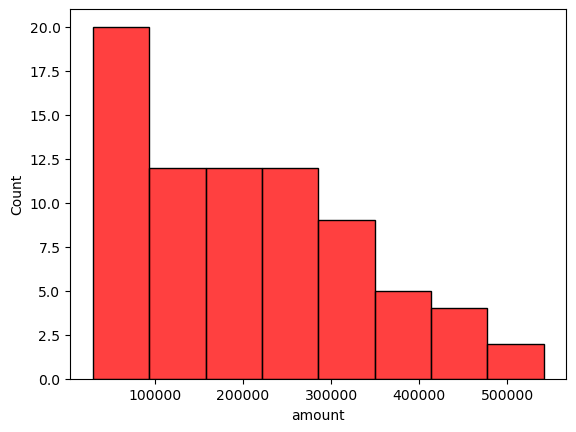

In [49]:
sns.histplot(x = 'amount',color = 'red', data = df1_bad)

## ======================================


## Good Loans (Blue):
Very high concentration in the 60k–120k range.

Count declines sharply as amount increases.

##  Bad Loans (Red):
Distribution is more flat and spread out due to imbalanced target class distribution (90% --> non-default , 10%--> default)

There are relatively more defaulters in higher loan amount.

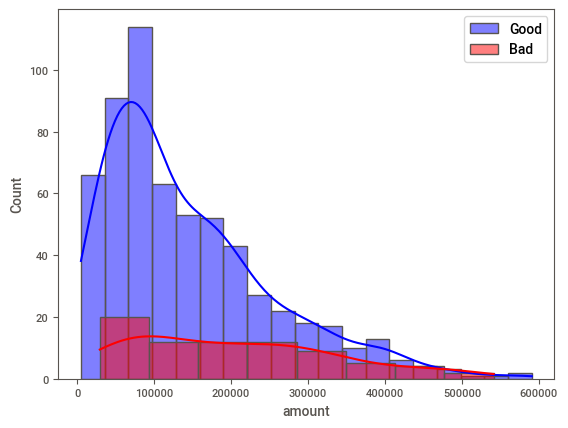

In [272]:
sns.histplot(x='amount', data=df1_good, color='blue', label='Good', kde=True)
sns.histplot(x='amount', data=df1_bad, color='red', label='Bad', kde=True)
plt.legend()

## ======================================

## Duration(non-default):

We can see that for good_loans/non-default loans, duration of the loan doesn't affect in predicting whether the loan is non-default since the distribution is pretty even.

<Axes: xlabel='duration', ylabel='Count'>

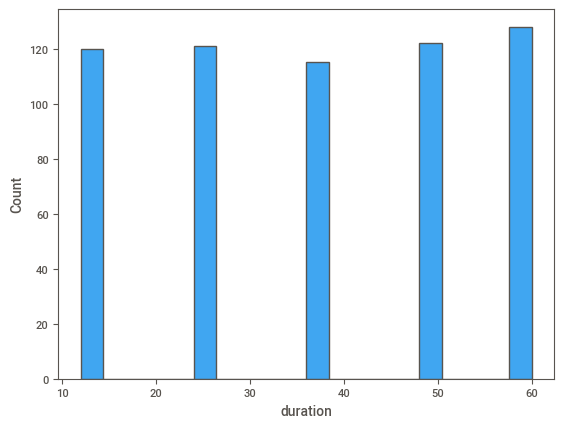

In [295]:
sns.histplot(x = 'duration', data = df1_good,bins = 20)

## ======================================

## Duration(default):

We can see that in the case of bad_loans/default loans it is the same case and the distribution is pretty evenly distributed across duration.

But we still see a slight decline if the duration is small suggesting that short-term loans are at a low risk of being marked as default loans.
This is most probably because of low financial risk arising in short period of time.

<Axes: xlabel='duration', ylabel='Count'>

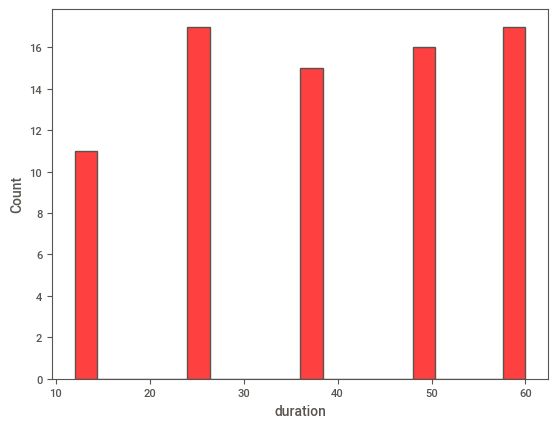

In [297]:
sns.histplot(x = 'duration', data = df1_bad, color = 'red', bins = 20)

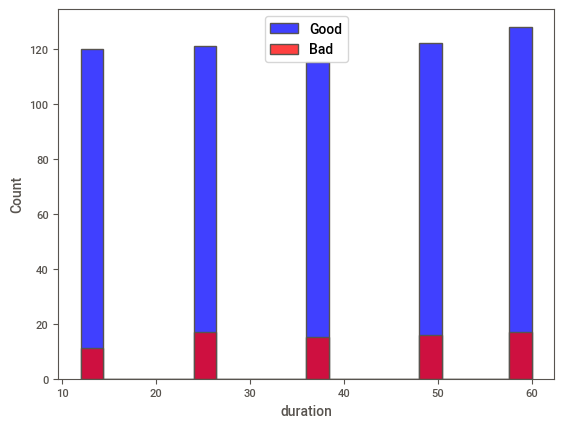

In [299]:
sns.histplot(x = 'duration', data = df1_good,color = 'blue',label = 'Good',bins = 20)
sns.histplot(x = 'duration', data = df1_bad, color = 'red',label = 'Bad', bins = 20)
plt.legend()

## ======================================

## Payments(non-default):

## Right-Skewed Distribution

Most non-default loans/good_loans have a monthly installment ranging between 2000-4000 suggesting that small installments are at lower risk of being marked as default loans due to low financial pressure.

<Axes: xlabel='payments', ylabel='Count'>

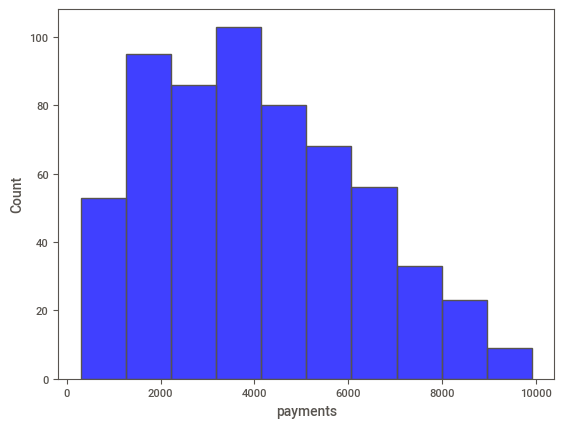

In [328]:
sns.histplot(x = 'payments' , data = df1_good,color = 'blue', bins = 10)

## ======================================

## Payments(default):

Monthly Payments ranging between 7000-8000 are at higher risk of being marked as default loans since high EMI burden(more financial risk).

<Axes: xlabel='payments', ylabel='Count'>

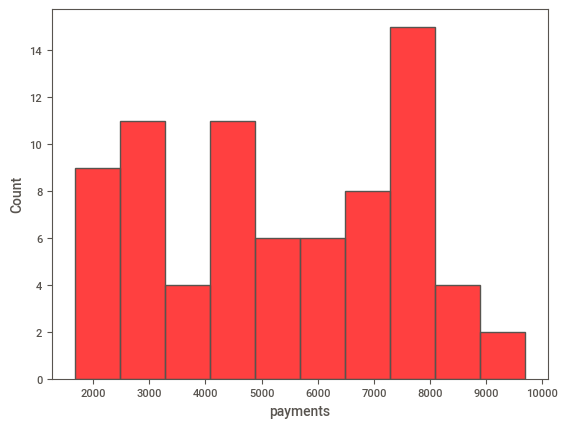

In [324]:
sns.histplot(x = 'payments' ,color = 'red', data = df1_bad,bins = 10)

## ======================================

## Frequency of payment:

POPLATEK MESICNE → Monthly

POPLATEK TYDNE → Weekly

POPLATEK PO OBRATU → irregular


# Most customers pay monthly (people having standard salaries)
Important feature because it helps the model understand that "monthly" payment frequency is the indicator of stability and low risk at being flagged as a default loan.

<Axes: xlabel='frequency', ylabel='count'>

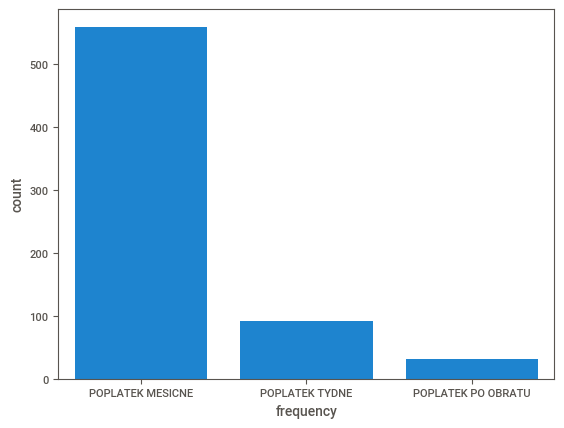

In [377]:
sns.countplot(data = df1 , x = 'frequency')


## ======================================

## Checking if the owner of the bank account resides in the same district or not from where the loan was granted

It looks like most of the default loans and non-default loans seemed to have owner's having no district mismatch , however we can still keep this as a geographic feature (or a minor risk signal) as owner's having district mismatch tend to increase the risk of their loan not being repaid.

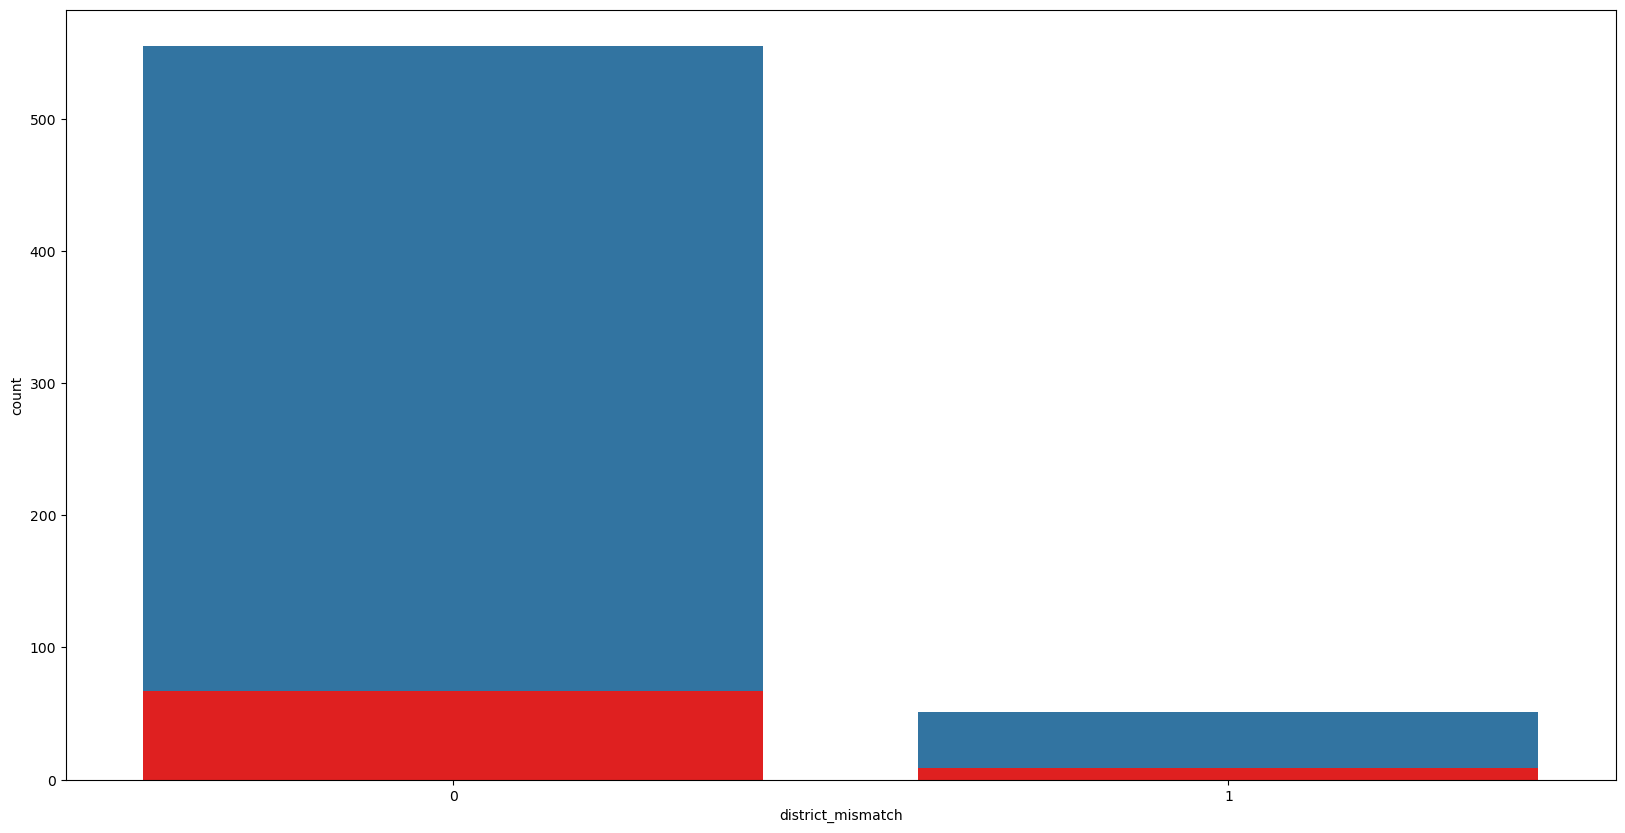

In [55]:
plt.figure(figsize=(20,10))
sns.countplot(x = 'district_mismatch', data = df1_good)
sns.countplot(x = 'district_mismatch',data = df1_bad,color = 'red')
plt.show()

## District Names:

We can observe that few district have very high count of people who have their loans marked as non-default as compared to those whose loans are defaulted signifying the financial and socio-economic condition of that district.

Some of the district at the ends of the plot only show non-default loans for their population , but we cant judge it from the limited data we have about our target class.

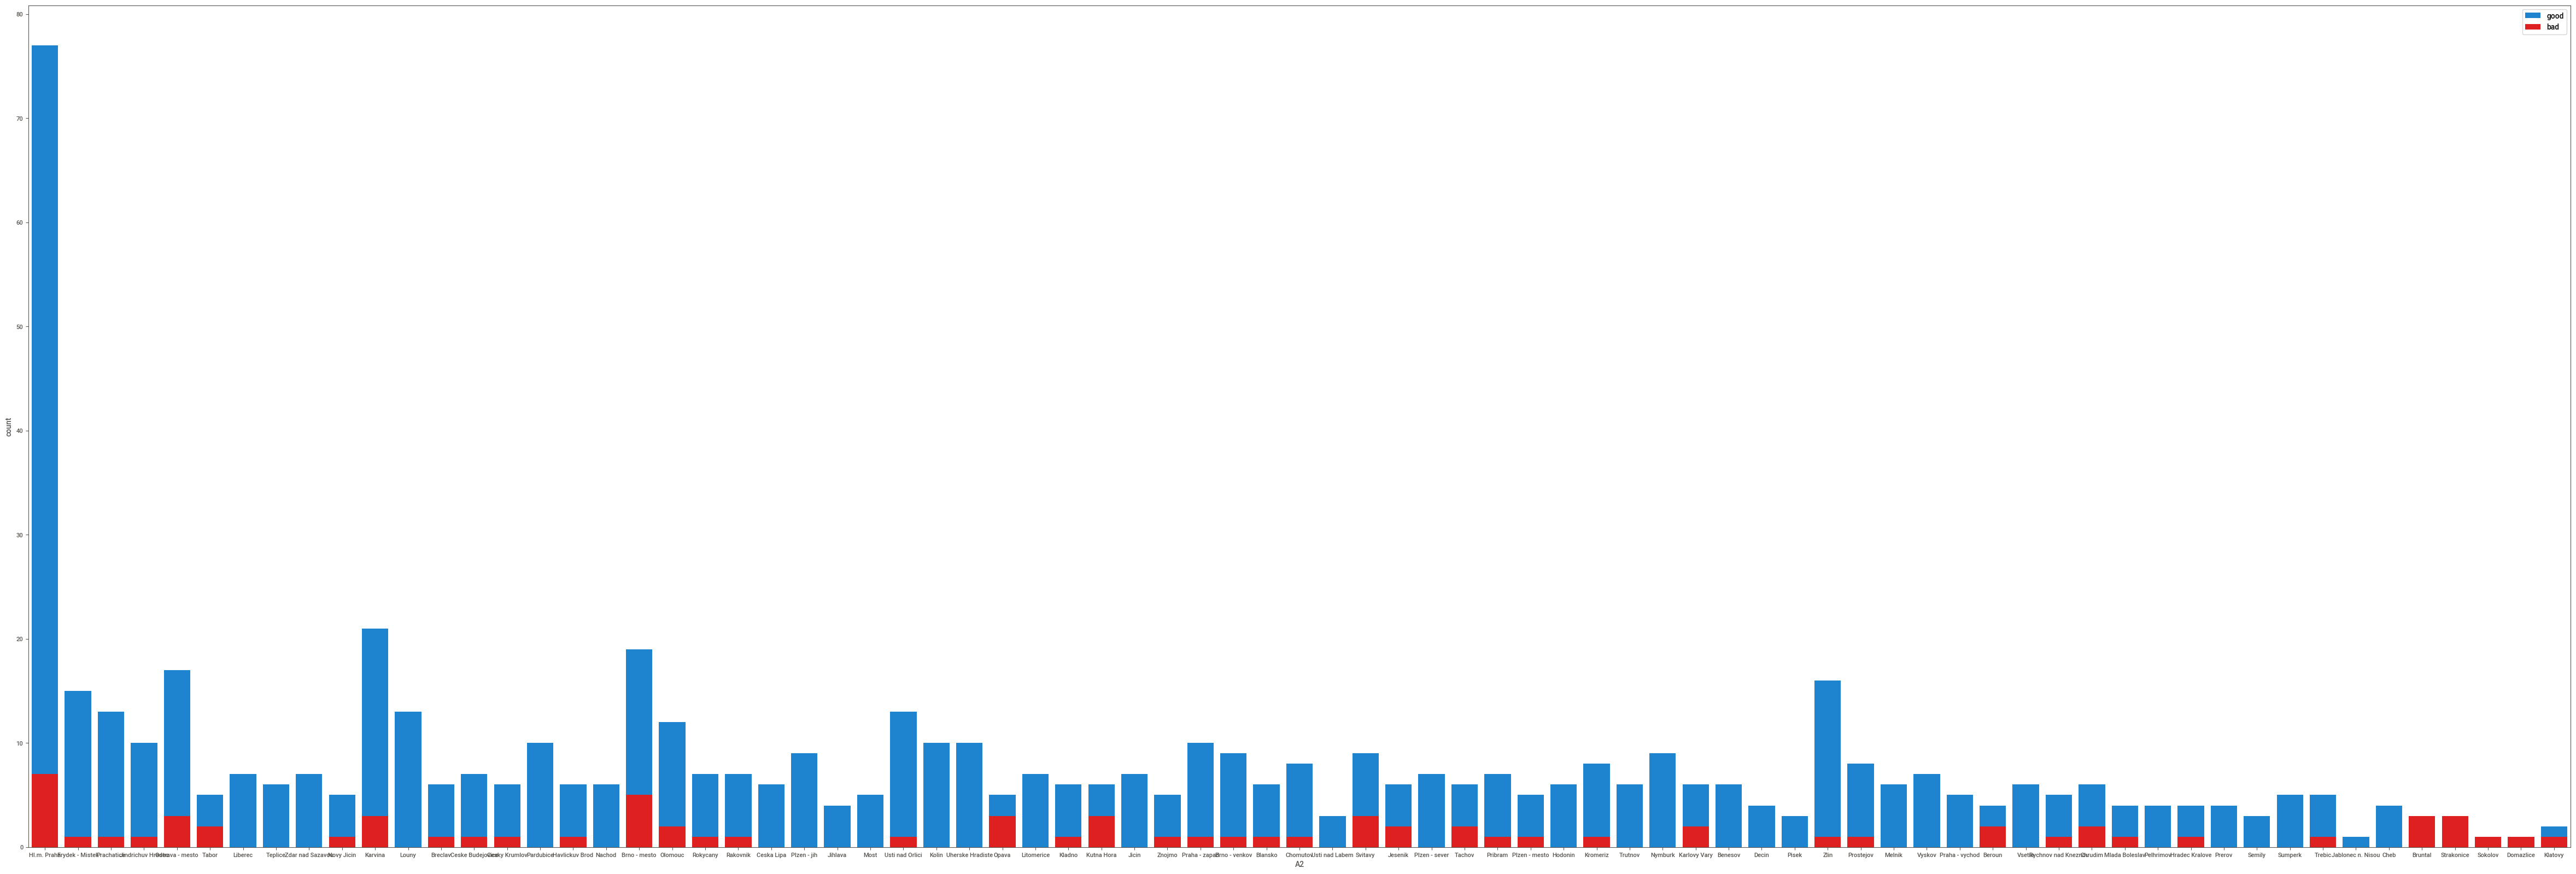

In [427]:
plt.figure(figsize=(60,20))
sns.countplot(x='A2', data = df1_good,label = 'good')
sns.countplot(x='A2', data = df1_bad, color = 'red',label = 'bad')
plt.legend()
plt.show()

## Client Region:

As we can see: -> 

1)North Moravia stands out as high-risk due to highest default loan count compared to other regions.

2)Prague and North Bohemia has a low default vs non-default loan ratio, showing stronger financial behavior.

3)Regions like South Bohemia and West Bohemia show higher proportion of bad loans relative to their total count indicating minor to moderate risk in these regions.



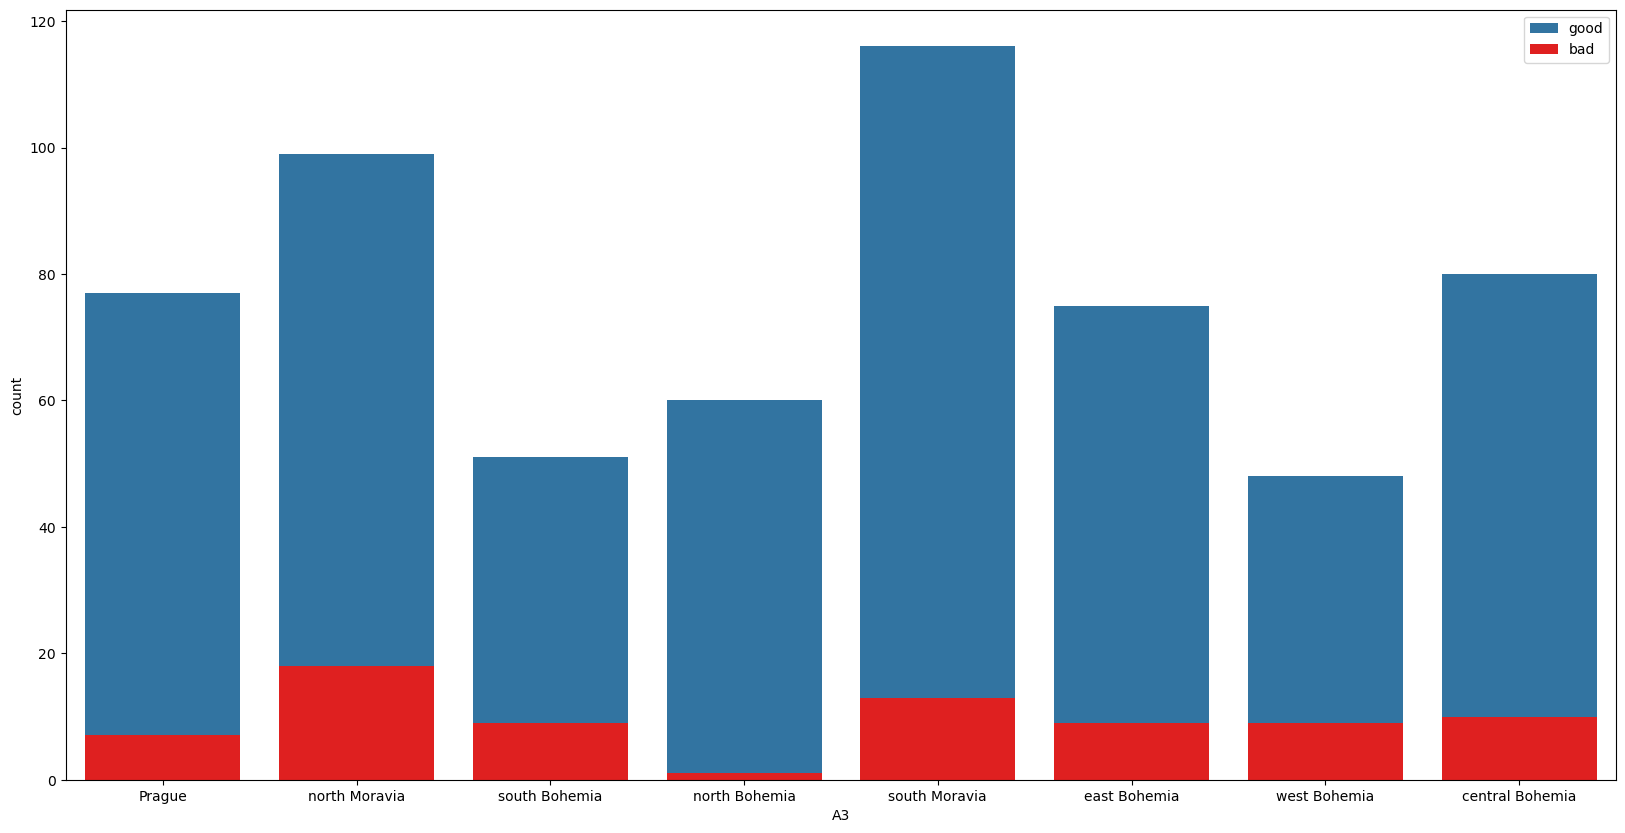

In [53]:
plt.figure(figsize=(20,10))
sns.countplot(x='A3', data = df1_good,label = 'good')
sns.countplot(x='A3', data = df1_bad, color = 'red',label = 'bad')
plt.legend()
plt.show()

## No of inhabitants in a district:

As we can observe that small to mid-range population districts tend to take loans more.

Small-population districts(<60,000) can be seen to have a major risk towards loans being default when compared to their population size.

Mid-range population districts (>100,000) tend to show very high non default loans in comparison to default loans indicating good economic strength.

Heavily populated districts (>1,000,000) tend to show more credit-worthiness in terms of loans being non default showcasing good financial and economic strength.


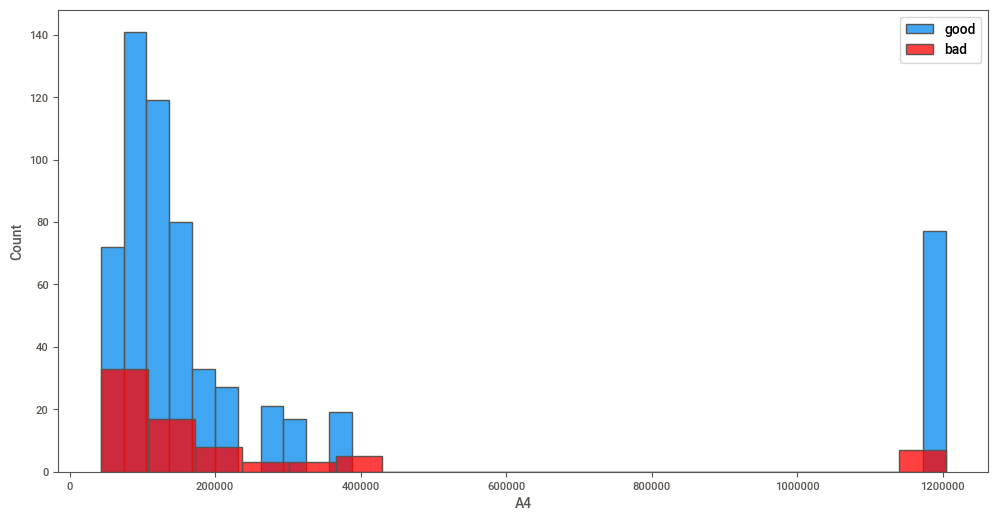

In [450]:
plt.figure(figsize=(12,6))
sns.histplot(x='A4', data = df1_good,label = 'good')
sns.histplot(x='A4', data = df1_bad, color = 'red',label = 'bad')
plt.legend()
plt.show()

## Urban population ratio in a district (in %)

1) Districts having 50-60% urbanization have higher default loan risk and show low total number of loans than other districts however good loans dominate in every area.
2) Even district having 100% urbanization show significant default loan risk which suggest that there is no linear trend to accurately capture the relationship between target class.

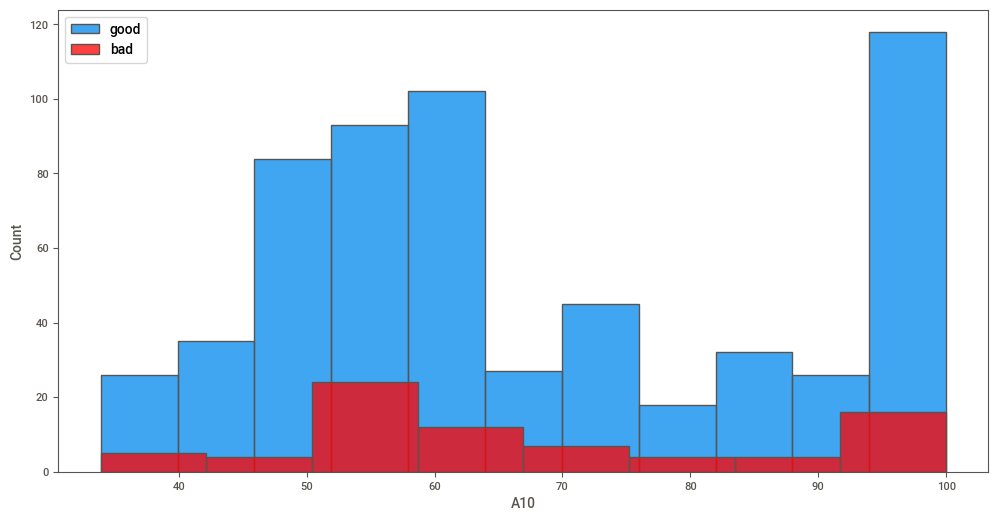

In [491]:
plt.figure(figsize=(12,6))
sns.histplot(x='A10', data = df1_good,label = 'good')
sns.histplot(x='A10', data = df1_bad, color = 'red',label = 'bad')
plt.legend()
plt.show()

## Average Salary in district: 

1) Low Average Salary individuals tend to have greater risk of not paying back the loan.
2) As average salary increases we can partially see a decline in default loans.

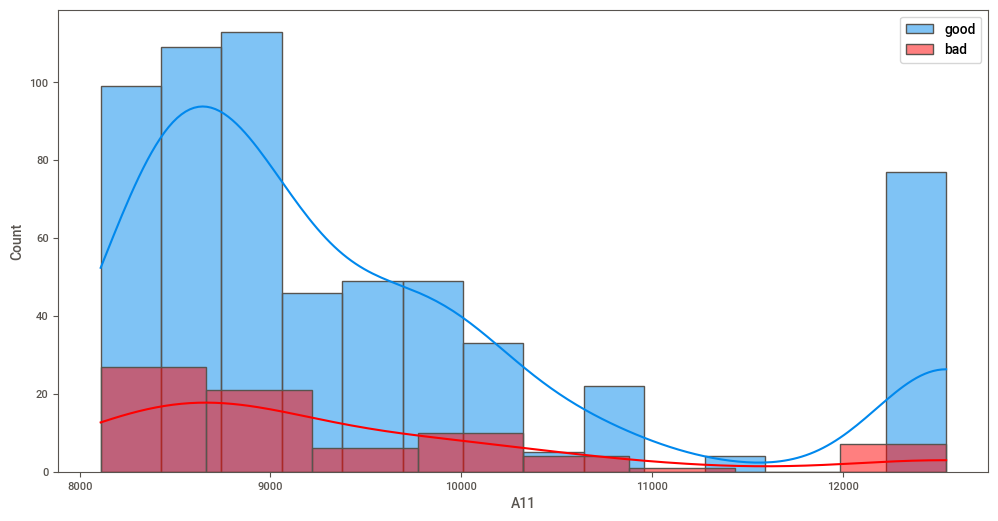

In [500]:
plt.figure(figsize=(12,6))
sns.histplot(x='A11', data = df1_good,label = 'good',kde=True)
sns.histplot(x='A11', data = df1_bad, color = 'red',label = 'bad',kde=True)
plt.legend()
plt.show()

## Unemployment Rates in a district(in %):

→ We can see that districts having low unemployment rate tend to have more total loans (due to their economic stability, encouraging banks to issue more loans). These areas have both good loans and bad loans but good loans dominating more ( suggesting more borrower capability to repay it back).

→ As we move towards the medium unemployment rate districts, we can see a decline in the total number of loans and a good amount of increase in the bad loans when compared to the total volume of loans. This region has the highest concentration of bad loans relative to good ones thus creating a risk zone in these district which banks may not see.

→ Lastly, high unemployment rate districts tend to have a very few loans being issued (possibly due to the fact that these regions are economically distressed hence banks dont find suitable applicants). There is still some amount of bad loans but the count is low.

## Loan Approval Sensitivity: 
1) As unemployment increases, banks approve fewer loans — possibly due to risk assessments or lack of eligible applicants.

## Risk Zone Identification:

2) The 2%–4% unemployment range is the risk tipping point, where defaults spike compared to good loans.

3) Might warrant special attention or stricter lending criteria.

## Policy Recommendation:
→ Introduce additional risk-based screening or increase required collateral in districts falling into the 2%–4% unemployment band.

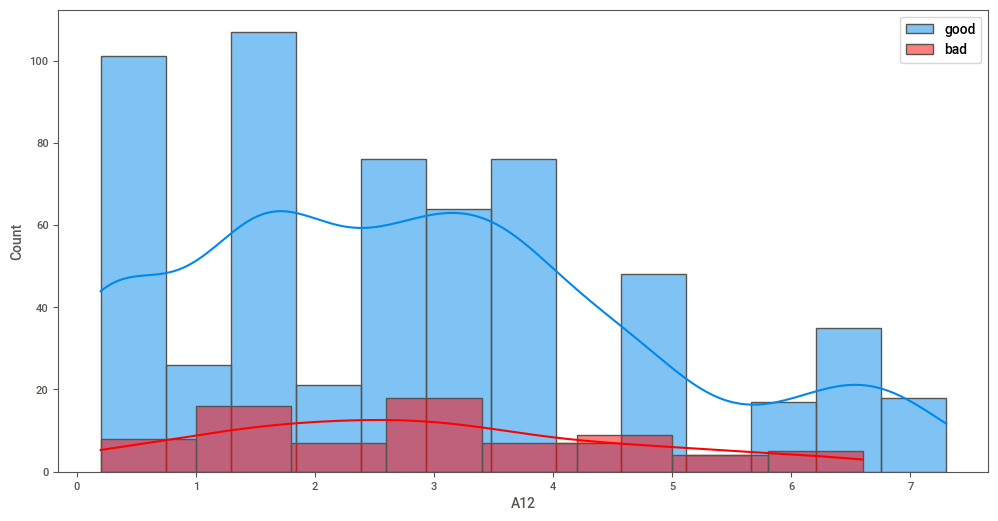

In [521]:
plt.figure(figsize=(12,6))
sns.histplot(x='A12', data = df1_good,label = 'good',kde=True)
sns.histplot(x='A12', data = df1_bad, color = 'red',label = 'bad',kde=True)
plt.legend()
plt.show()

## Unemployment Rate of women in a district(in %):

→ Pretty much the same insights as the above plot.

→ Lower unemployment rate of women indicate a stronger local economy and better repaying capability of the mass.

→ Districts having medium unemployment rate of women show the maximum count of default loans relative to the good ones flagging these districts as the "tipping zone" for credit risk assessment by the banks.


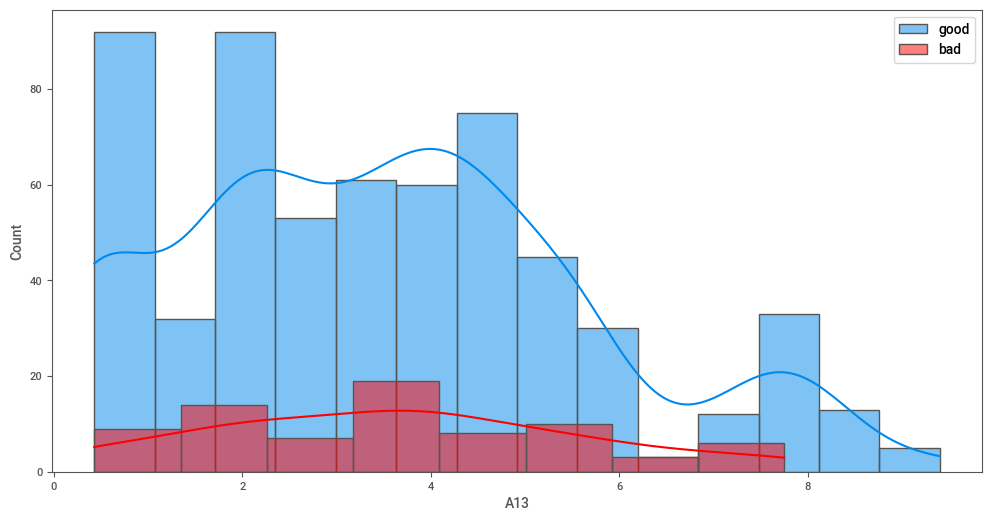

In [515]:
plt.figure(figsize=(12,6))
sns.histplot(x='A13', data = df1_good,label = 'good',kde=True)
sns.histplot(x='A13', data = df1_bad, color = 'red',label = 'bad',kde=True)
plt.legend()
plt.show()

## Number of entrepreneurs per 1000 inhabitants:

→ It's a non linear pattern between this column and the target class.

→ Fewer entrepreneurs --> less entrepreneurial activity --> less loans being issued

→ At around (90-110) entrepreneurs there is peak in total loans. Defaults rise but so does good loans and good loans dominate this area. There is high entreprenurial demand in these regions and default peak observed here is likely due to newer and riskier ventures which haven't flourished in the industry yet.

→ At around (120-150) entrepreneurs there is flat decline in the total number of loans. This region has the maximum concentration of default loans relative to the good ones.

→ At (>150) entrepreneurs there is as sudden rise in total loans and low bad count is also observed indicating that these districts are mature and stable with high business activity and good repayment behaviour.



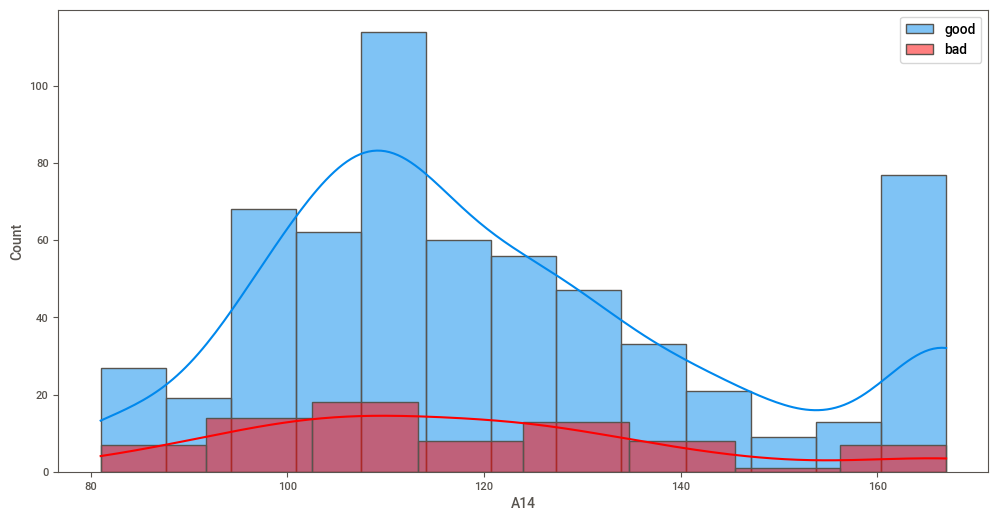

In [526]:
plt.figure(figsize=(12,6))
sns.histplot(x='A14', data = df1_good,label = 'good',kde=True)
sns.histplot(x='A14', data = df1_bad, color = 'red',label = 'bad',kde=True)
plt.legend()
plt.show()

NameError: name 'df1' is not defined

In [50]:
df1['status'].value_counts()

status
C    403
A    203
D     45
B     31
Name: count, dtype: int64

In [51]:
df1.isnull().sum()

loan_id                        0
account_id                     0
loan_date                      0
amount                         0
duration                       0
payments                       0
status                         0
district_id_client             0
frequency                      0
account_open_date              0
client_id                      0
district_id_account            0
birth_date                     0
gender                         0
district_mismatch              0
district_id                    0
A2                             0
A3                             0
A4                             0
A5                             0
A6                             0
A7                             0
A8                             0
A9                             0
A10                            0
A11                            0
A12                            8
A13                            0
A14                            0
A15                            8
A16       

In [579]:
feature_cols = ['amount', 'duration', 'payments','frequency_encoded','district_mismatch','A4', 'A5', 'A6', 'A7',
       'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16',
       'person_age', 'account_age_days', 'account_age_years',
       'monthly_burden_ratio', 'loan_amount_to_income_ratio']
cols_to_be_dropped = ['loan_id', 'account_id', 'client_id', 'district_id',
             'district_id_client', 'district_id_account',
             'loan_date', 'account_open_date', 'birth_date', 'A2', 'A3', 'loan_date', 'account_open_date','gender']

In [581]:
feature_cols_1 = ['amount', 'duration', 'payments','frequency_encoded','district_mismatch','A4', 'A10', 'A11', 'A12', 'A13', 'A14',
       'person_age', 'account_age_days', 'account_age_years',
       'monthly_burden_ratio', 'loan_amount_to_income_ratio']
cols_to_be_dropped_1 = ['loan_id', 'account_id', 'client_id', 'district_id',
             'district_id_client', 'district_id_account',
             'loan_date', 'account_open_date', 'birth_date', 'A2', 'A3', 'loan_date', 'account_open_date','gender','A5', 'A6', 'A7',
       'A8', 'A9','A15', 'A16']

In [593]:
df3 = df1.copy()
df3.drop(labels = cols_to_be_dropped_1,axis = 1, inplace = True)

In [545]:
df3.columns

Index(['amount', 'duration', 'payments', 'status', 'frequency',
       'district_mismatch', 'A4', 'A10', 'A11', 'A12', 'A13', 'A14',
       'person_age', 'account_age_days', 'account_age_years',
       'monthly_burden_ratio', 'loan_amount_to_income_ratio'],
      dtype='object')

In [595]:
# Map: A, C = not defaulted (0), B, D = defaulted (1)
df3['default'] = df3['status'].map({
    'A': 0,  # Paid on time
    'C': 0,  # Paid late, but eventually paid
    'B': 1,  # Unpaid at term
    'D': 1   # Defaulted
})

In [597]:
df2 = df1.copy()
df2.drop(labels = cols_to_be_dropped,axis = 1,inplace = True)

In [54]:
df2.columns 

Index(['amount', 'duration', 'payments', 'status', 'frequency',
       'district_mismatch', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11',
       'A12', 'A13', 'A14', 'A15', 'A16', 'person_age', 'account_age_days',
       'account_age_years', 'monthly_burden_ratio',
       'loan_amount_to_income_ratio'],
      dtype='object')

In [599]:
# Map: A, C = not defaulted (0), B, D = defaulted (1)
df2['default'] = df2['status'].map({
    'A': 0,  # Paid on time
    'C': 0,  # Paid late, but eventually paid
    'B': 1,  # Unpaid at term
    'D': 1   # Defaulted
})

In [56]:
df2['default'].head()

0    0
1    1
2    0
3    1
4    0
Name: default, dtype: int64

In [57]:
target_col = ['default'] 

In [601]:
df2[['A12', 'A15']] = df2[['A12', 'A15']].fillna(df2[['A12', 'A15']].mean())

In [603]:
df2.drop(labels = ['status'],axis = 1, inplace = True)

In [518]:
df[['A12','A13']].corr()

,A12,A13
A12,1.00000,0.99006
A13,0.99006,1.00000


<Axes: >

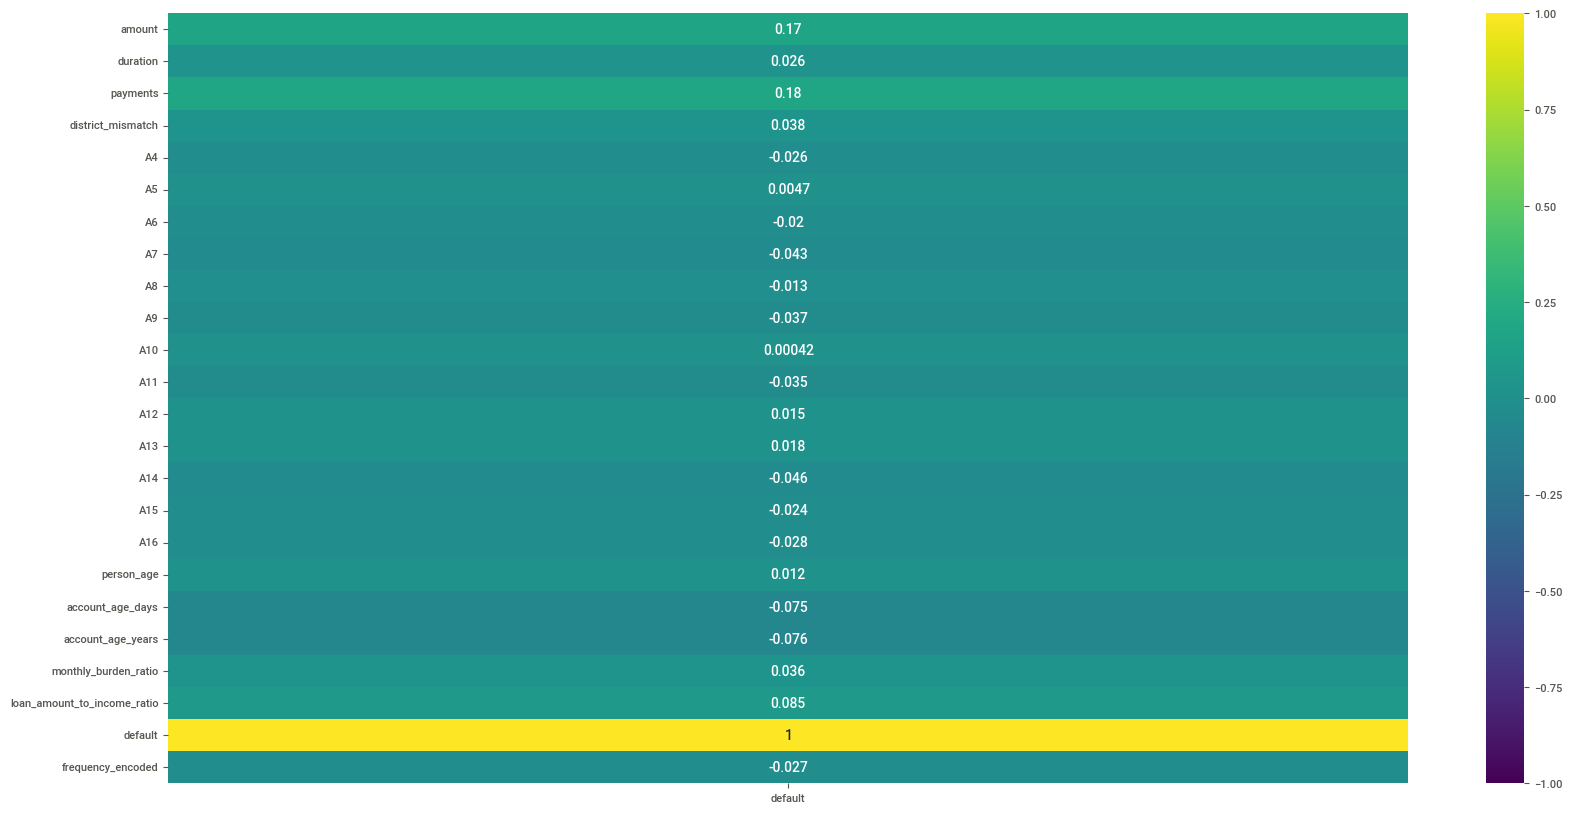

In [368]:
plt.figure(figsize=(20,10))


sns.heatmap(data = df2.corr()[['default']] , annot=True, cmap = 'viridis',vmin = -1 , vmax = 1)

## TARGET ENCODING FREQUENCY COLUMN USING K-FOLD VALIDATION / OOF VALIDATION

## NORMAL TARGET ENCODING EXPOSES/LEAKS VALUABLE INFO REGARDING TARGET VARIABLE HENCE WE USE K-FOLD VALIDATION 


In [61]:
import pandas as pd
from sklearn.model_selection import KFold

def target_encode(train_series , target , n_splits = 5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    encoded = pd.Series(index=train_series.index , dtype=float)
    for train_idx , val_idx in kf.split(train_series):
        train_fold = train_series.iloc[train_idx]
        # print(train_fold)
        val_fold = train_series.iloc[val_idx]
        # print(val_fold)
        target_fold = target.iloc[train_idx]
        # print(target_fold)
        
        means = target_fold.groupby(train_fold).mean()
        # print(means)
        encoded.iloc[val_idx] = val_fold.map(means)
    return encoded
    

In [605]:
df2['frequency_encoded'] = target_encode(df2['frequency'], df2['default'])


In [63]:
df2['frequency_encoded']

0      0.100228
1      0.109375
2      0.109375
3      0.107383
4      0.126761
         ...   
677    0.109375
678    0.109375
679    0.126761
680    0.101322
681    0.107383
Name: frequency_encoded, Length: 682, dtype: float64

In [64]:
df2.columns

Index(['amount', 'duration', 'payments', 'frequency', 'district_mismatch',
       'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14',
       'A15', 'A16', 'person_age', 'account_age_days', 'account_age_years',
       'monthly_burden_ratio', 'loan_amount_to_income_ratio', 'default',
       'frequency_encoded'],
      dtype='object')

In [607]:
df2.drop(labels = ['frequency'],axis = 1, inplace=True)

In [66]:
df2.columns

Index(['amount', 'duration', 'payments', 'district_mismatch', 'A4', 'A5', 'A6',
       'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16',
       'person_age', 'account_age_days', 'account_age_years',
       'monthly_burden_ratio', 'loan_amount_to_income_ratio', 'default',
       'frequency_encoded'],
      dtype='object')

In [67]:
df2.corr()['default'].sort_values(ascending=False)

default                        1.000000
payments                       0.182440
amount                         0.167525
loan_amount_to_income_ratio    0.084683
district_mismatch              0.038062
monthly_burden_ratio           0.036220
duration                       0.025823
A13                            0.018071
A12                            0.014917
person_age                     0.011637
A5                             0.004688
A10                            0.000419
A8                            -0.013263
A6                            -0.020196
A15                           -0.024402
A4                            -0.026483
frequency_encoded             -0.027336
A16                           -0.027963
A11                           -0.034555
A9                            -0.037178
A7                            -0.042940
A14                           -0.046420
account_age_days              -0.075247
account_age_years             -0.075811
Name: default, dtype: float64

In [68]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

In [69]:

models = {
    "KNeighbors Classifier": KNeighborsClassifier(),  # ⚠️ No direct support; handle via resampling like SMOTE
    
    "DecisionTree Classifier": DecisionTreeClassifier(class_weight='balanced'),
    
    "RandomForest Classifier": RandomForestClassifier(class_weight='balanced'),
    
    "AdaBoost Classifier": AdaBoostClassifier(),  # ⚠️ Base estimator doesn’t handle class_weight, use SMOTE or adjust weights manually
    
    "Support Vector Classifier": SVC(class_weight='balanced', probability=True),
    
    "Logistic Regression": LogisticRegression(class_weight='balanced', solver='liblinear'),
    
    "CatBoost Classifier": CatBoostClassifier(auto_class_weights='Balanced', verbose=False),
    
    "XGB Classifier": XGBClassifier(
        scale_pos_weight=606 / 76,  # ratio of non-default / default
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
}
    

In [70]:
def evaluate_model(true,predicted):
    print(classification_report(true,predicted))
    print('\n')
    print('\n')
    print(confusion_matrix(true,predicted))

In [611]:
df3['frequency_encoded'] = target_encode(df3['frequency'], df3['default'])


In [629]:
X1 = df3[feature_cols_1]
y1 = df3['default']

In [685]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1,stratify=y1, test_size=0.3, random_state=42)



(477, 16)

In [627]:
df3['A12'] = df3['A12'].fillna(df2['A12'].mean())

In [573]:
df3.isnull().sum()

amount                         0
duration                       0
payments                       0
status                         0
frequency                      0
district_mismatch              0
A4                             0
A10                            0
A11                            0
A12                            0
A13                            0
A14                            0
person_age                     0
account_age_days               0
account_age_years              0
monthly_burden_ratio           0
loan_amount_to_income_ratio    0
default                        0
frequency_encoded              0
dtype: int64

In [619]:
X = df2[feature_cols]
y = df2['default']


In [621]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.3, random_state=42)


In [181]:
type(X_train)

pandas.core.frame.DataFrame

In [74]:
!pip install shap

In [75]:
import shap 

In [185]:
def model_training(models,X_train, X_test, y_train,y_test):
    
    import shap


    X_train_display = pd.DataFrame(X_train, columns=X_train.columns)
    X_test_display = pd.DataFrame(X_test, columns=X_test.columns)

    for i in range(len(models)):
        name = list(models.keys())[i]
        model = list(models.values())[i]
        model.fit(X_train,y_train)
        predictions = model.predict(X_test)
        print("="*35)
        print("\n")
        print("Name of Model: ",name)
        print("\n")
        evaluate_model(y_test,predictions)
        print("="*60)
        print("\n")
        try:
            if name in ['XGB Classifier', 'RandomForest Classifier', 'DecisionTree Classifier', 'CatBoost Classifier']:
                print("Generating SHAP summary plot")
    
                if 'CatBoost' in name:
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X_test_display)
                elif 'XGB' in name or 'RandomForest' in name or 'DecisionTree' in name:
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X_test_display)
                else:
                    explainer = shap.Explainer(model, X_train_display)
                    shap_values = explainer(X_test_display)
                
                shap.summary_plot(shap_values, X_test_display, plot_type='bar', max_display=10)
                shap.summary_plot(shap_values, X_test_display, plot_type='bee swarm', max_display=10)
        
        except Exception as e:
            print(f"❌ SHAP failed for {name} due to: {e}")

            
                
        
            


        
    

In [667]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.3, random_state=42)



# 2. Then apply SMOTE only to training
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)



In [669]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1,stratify=y1, test_size=0.3, random_state=42)


# 2. Then apply SMOTE only to training
smote1 = SMOTE(random_state=42, k_neighbors=3)
X_train_sm_1, y_train_sm_1 = smote1.fit_resample(X_train1, y_train1)



Name of Model:  KNeighbors Classifier


              precision    recall  f1-score   support

           0       0.88      0.96      0.92       182
           1       0.00      0.00      0.00        23

    accuracy                           0.85       205
   macro avg       0.44      0.48      0.46       205
weighted avg       0.78      0.85      0.82       205





[[175   7]
 [ 23   0]]




Name of Model:  DecisionTree Classifier


              precision    recall  f1-score   support

           0       0.89      0.88      0.88       182
           1       0.12      0.13      0.12        23

    accuracy                           0.80       205
   macro avg       0.50      0.50      0.50       205
weighted avg       0.80      0.80      0.80       205





[[160  22]
 [ 20   3]]


Generating SHAP summary plot


<Figure size 640x480 with 0 Axes>

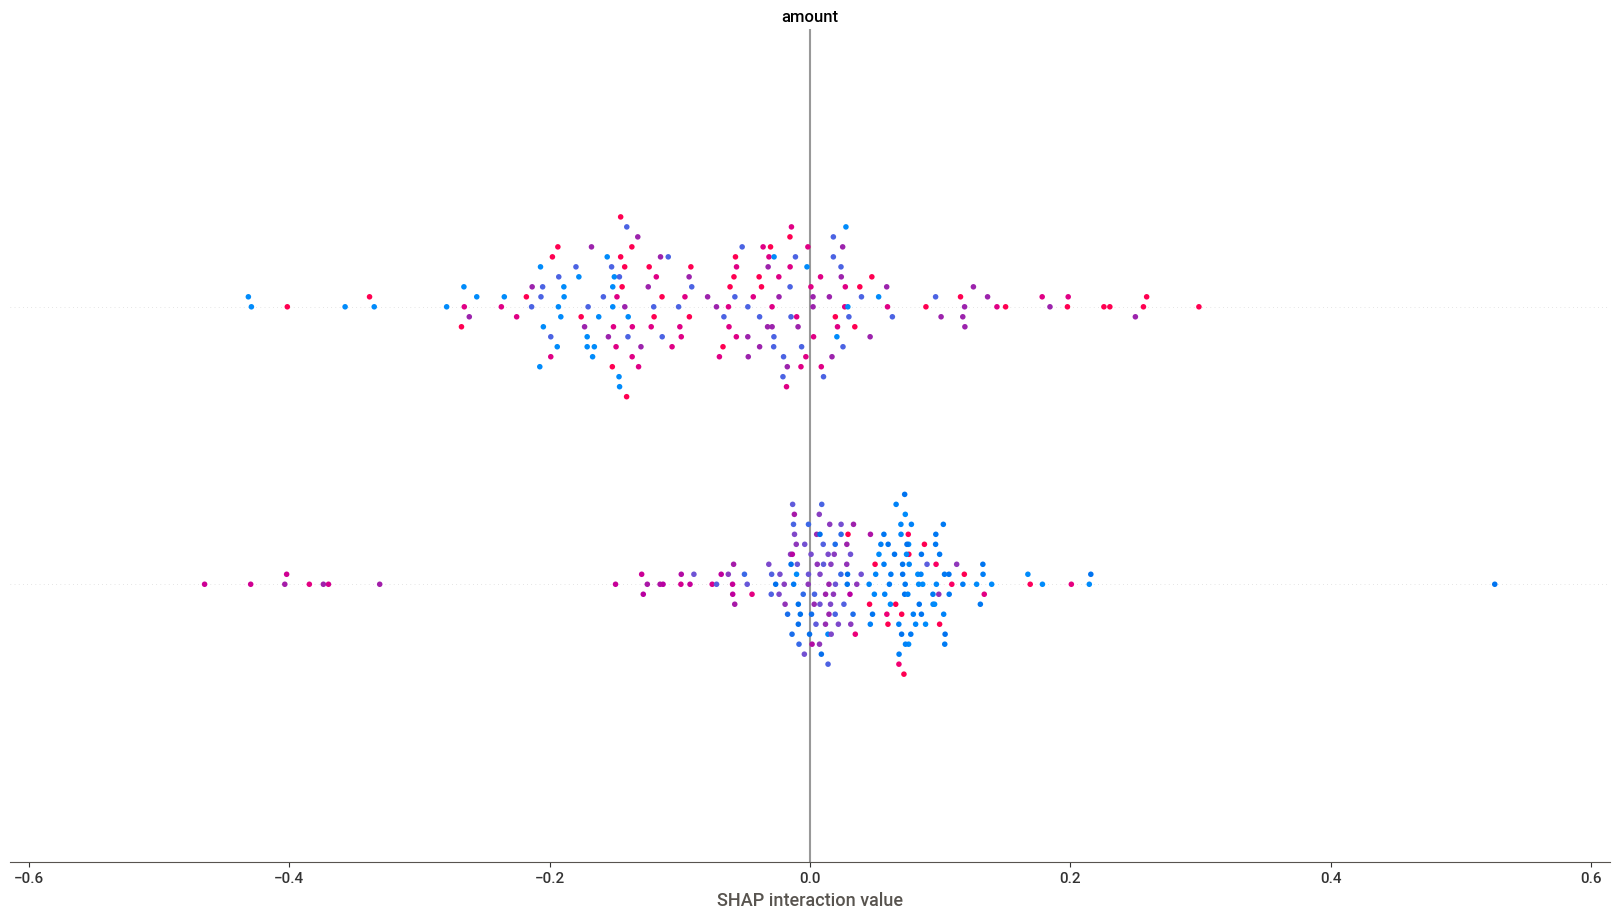

<Figure size 640x480 with 0 Axes>

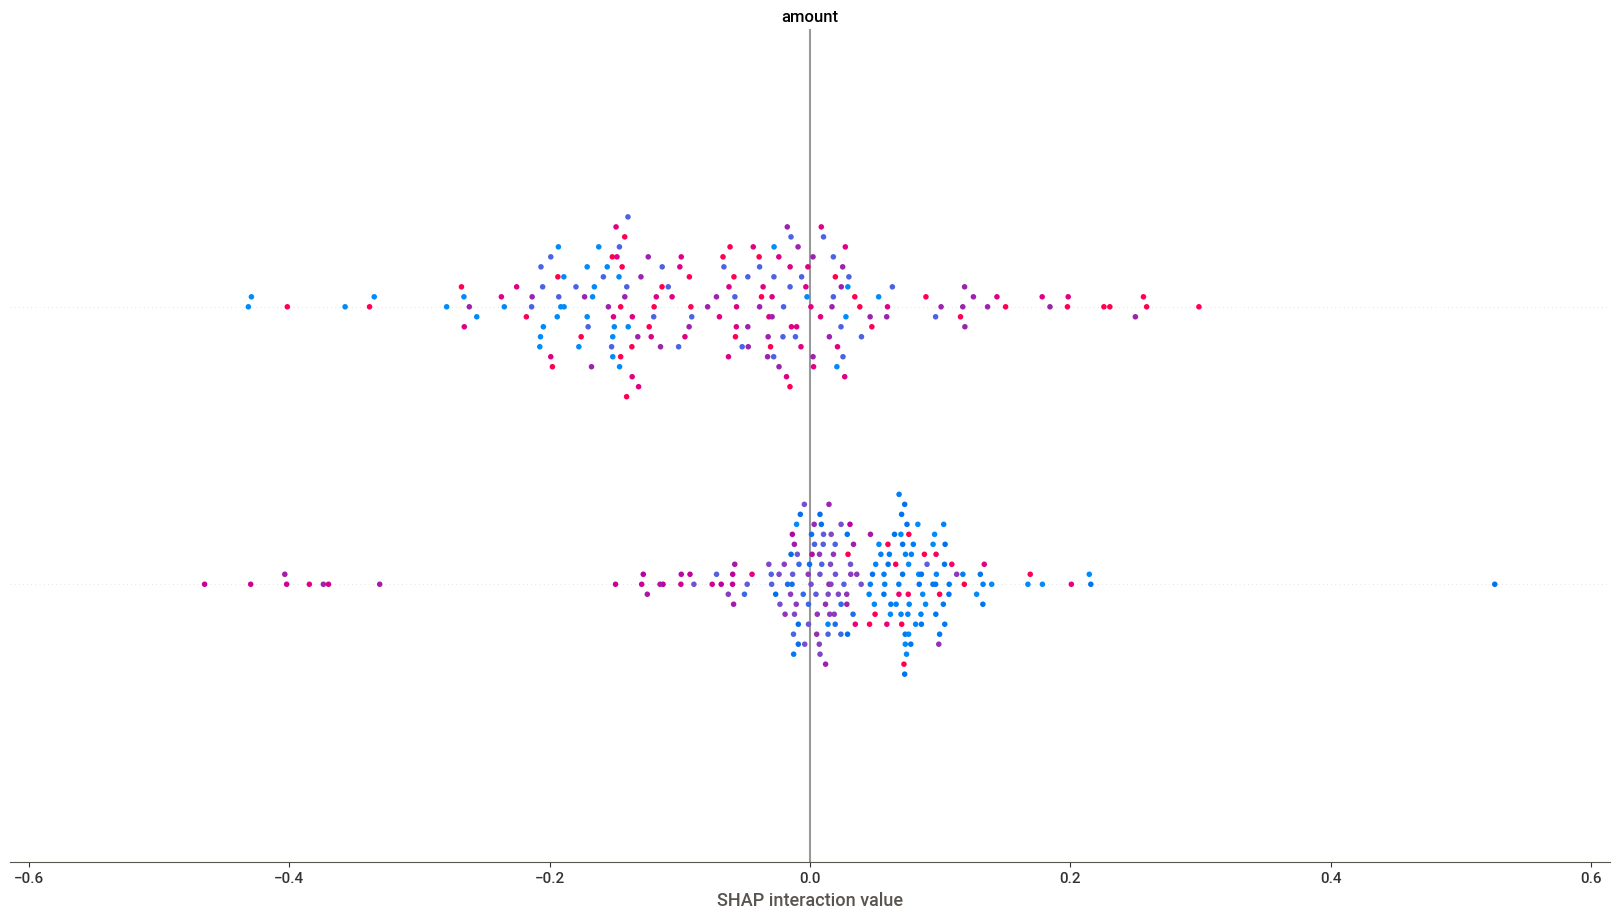



Name of Model:  RandomForest Classifier


              precision    recall  f1-score   support

           0       0.89      1.00      0.94       182
           1       1.00      0.04      0.08        23

    accuracy                           0.89       205
   macro avg       0.95      0.52      0.51       205
weighted avg       0.90      0.89      0.85       205





[[182   0]
 [ 22   1]]


Generating SHAP summary plot


<Figure size 640x480 with 0 Axes>

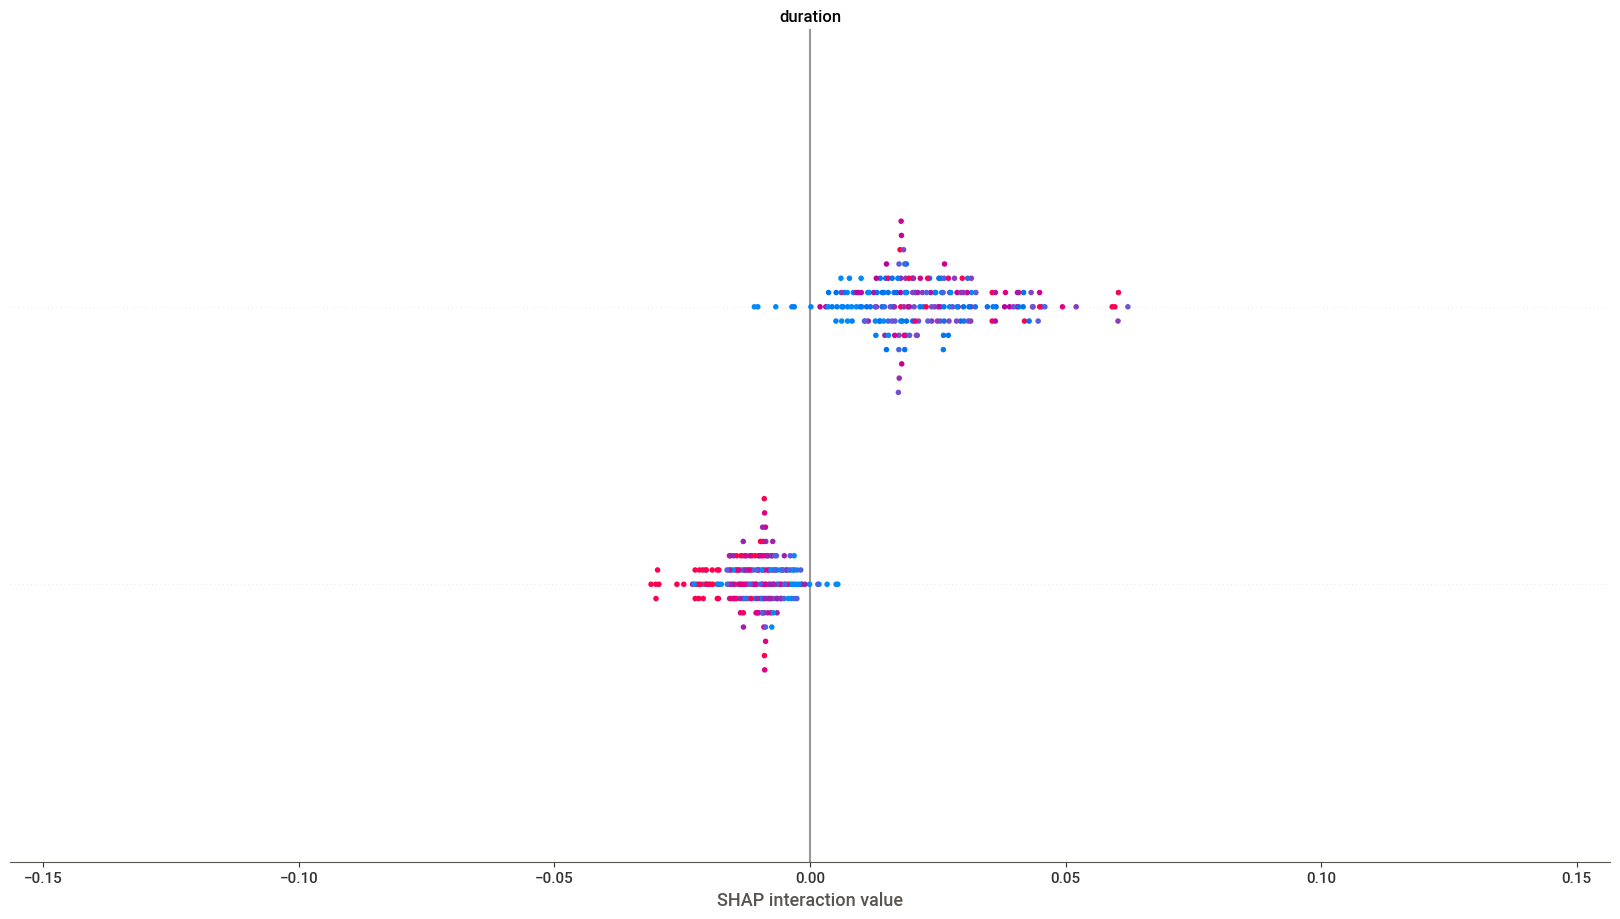

<Figure size 640x480 with 0 Axes>

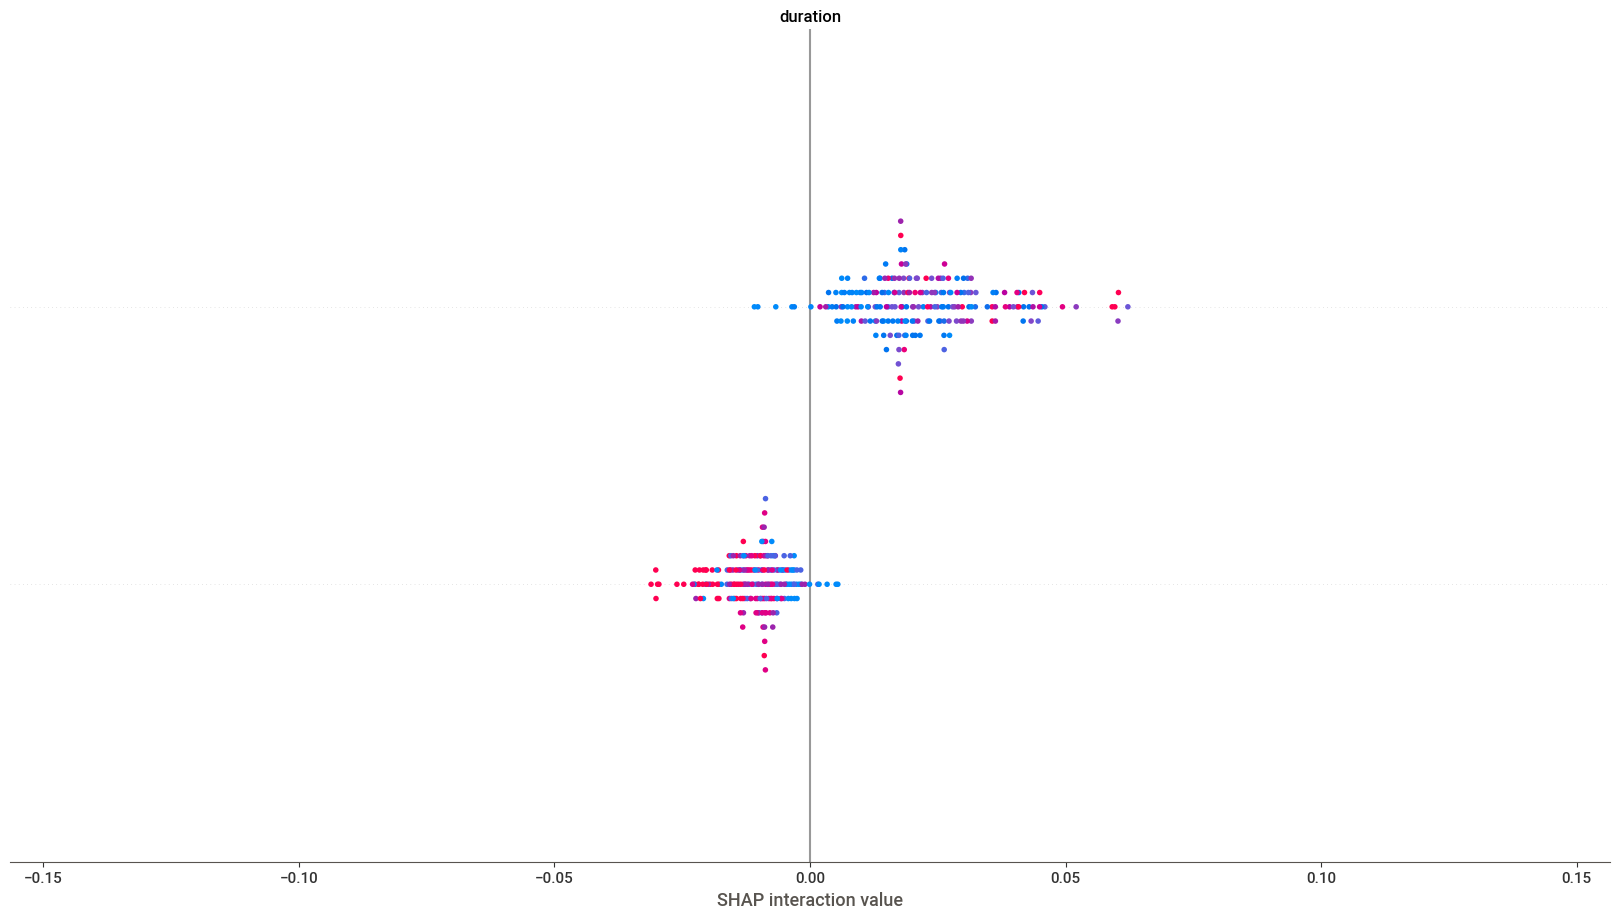

C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(




Name of Model:  AdaBoost Classifier


              precision    recall  f1-score   support

           0       0.89      0.95      0.92       182
           1       0.18      0.09      0.12        23

    accuracy                           0.85       205
   macro avg       0.54      0.52      0.52       205
weighted avg       0.81      0.85      0.83       205





[[173   9]
 [ 21   2]]




Name of Model:  Support Vector Classifier


              precision    recall  f1-score   support

           0       0.93      0.55      0.69       182
           1       0.16      0.70      0.26        23

    accuracy                           0.57       205
   macro avg       0.55      0.62      0.48       205
weighted avg       0.85      0.57      0.64       205





[[100  82]
 [  7  16]]




Name of Model:  Logistic Regression


              precision    recall  f1-score   support

           0       0.90      0.61      0.73       182
           1       0.13      0.48      0.21        23

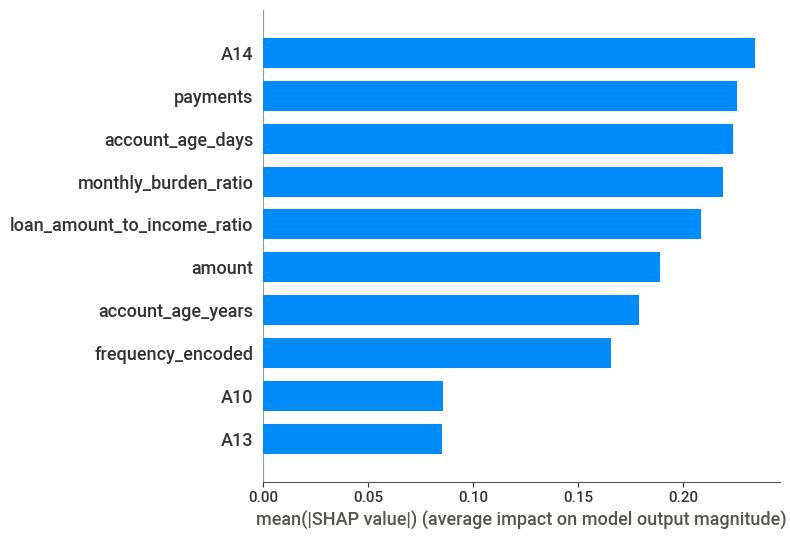

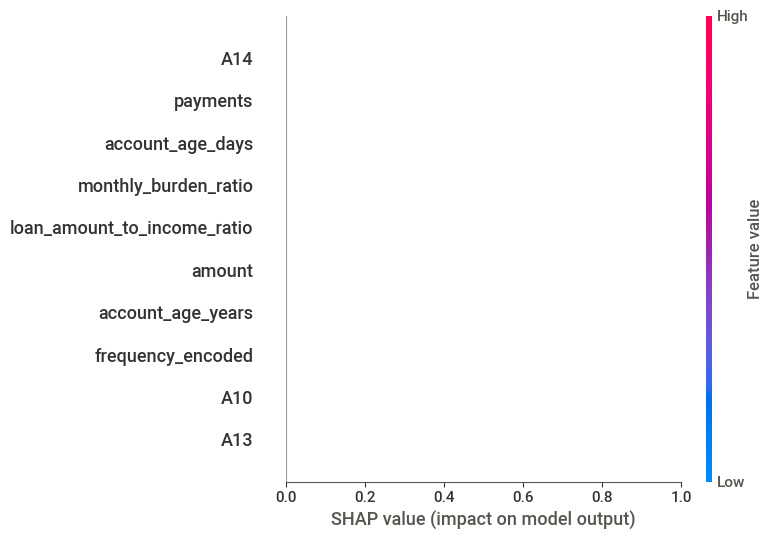



Name of Model:  XGB Classifier


              precision    recall  f1-score   support

           0       0.88      0.93      0.91       182
           1       0.07      0.04      0.05        23

    accuracy                           0.83       205
   macro avg       0.48      0.49      0.48       205
weighted avg       0.79      0.83      0.81       205





[[169  13]
 [ 22   1]]


Generating SHAP summary plot
❌ SHAP failed for XGB Classifier due to: underflow encountered in nextafter


C:\Users\KIIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:19:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [623]:
model_training(models,X_train,X_test,y_train,y_test)



Name of Model:  KNeighbors Classifier


              precision    recall  f1-score   support

           0       0.88      0.96      0.92       182
           1       0.00      0.00      0.00        23

    accuracy                           0.85       205
   macro avg       0.44      0.48      0.46       205
weighted avg       0.78      0.85      0.82       205





[[175   7]
 [ 23   0]]




Name of Model:  DecisionTree Classifier


              precision    recall  f1-score   support

           0       0.89      0.91      0.90       182
           1       0.11      0.09      0.10        23

    accuracy                           0.82       205
   macro avg       0.50      0.50      0.50       205
weighted avg       0.80      0.82      0.81       205





[[166  16]
 [ 21   2]]


Generating SHAP summary plot


<Figure size 640x480 with 0 Axes>

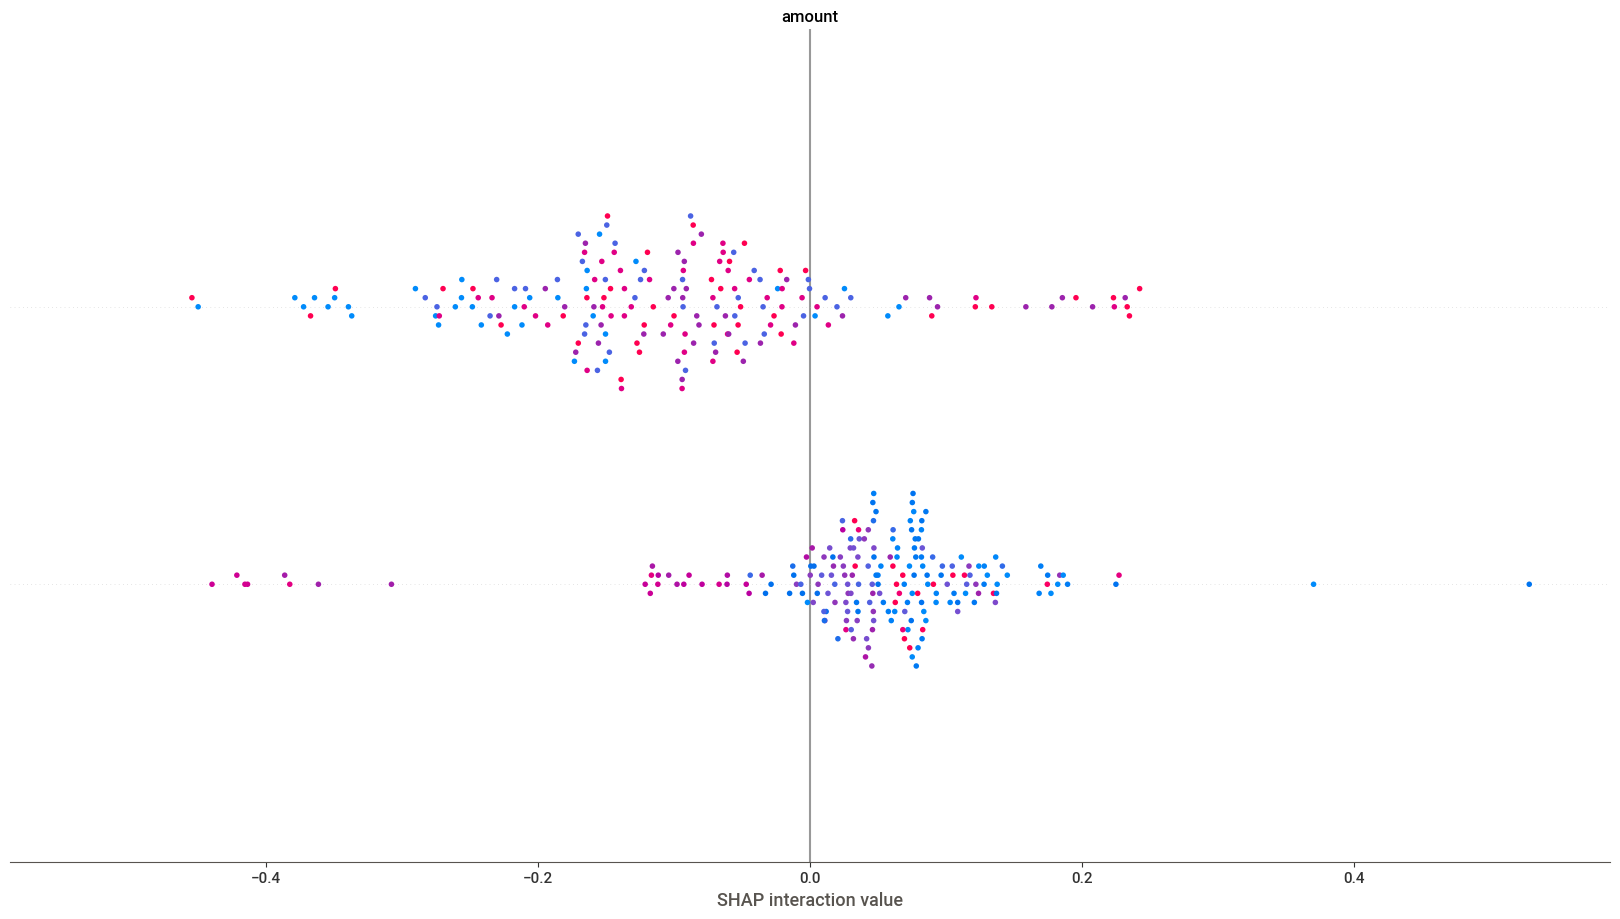

<Figure size 640x480 with 0 Axes>

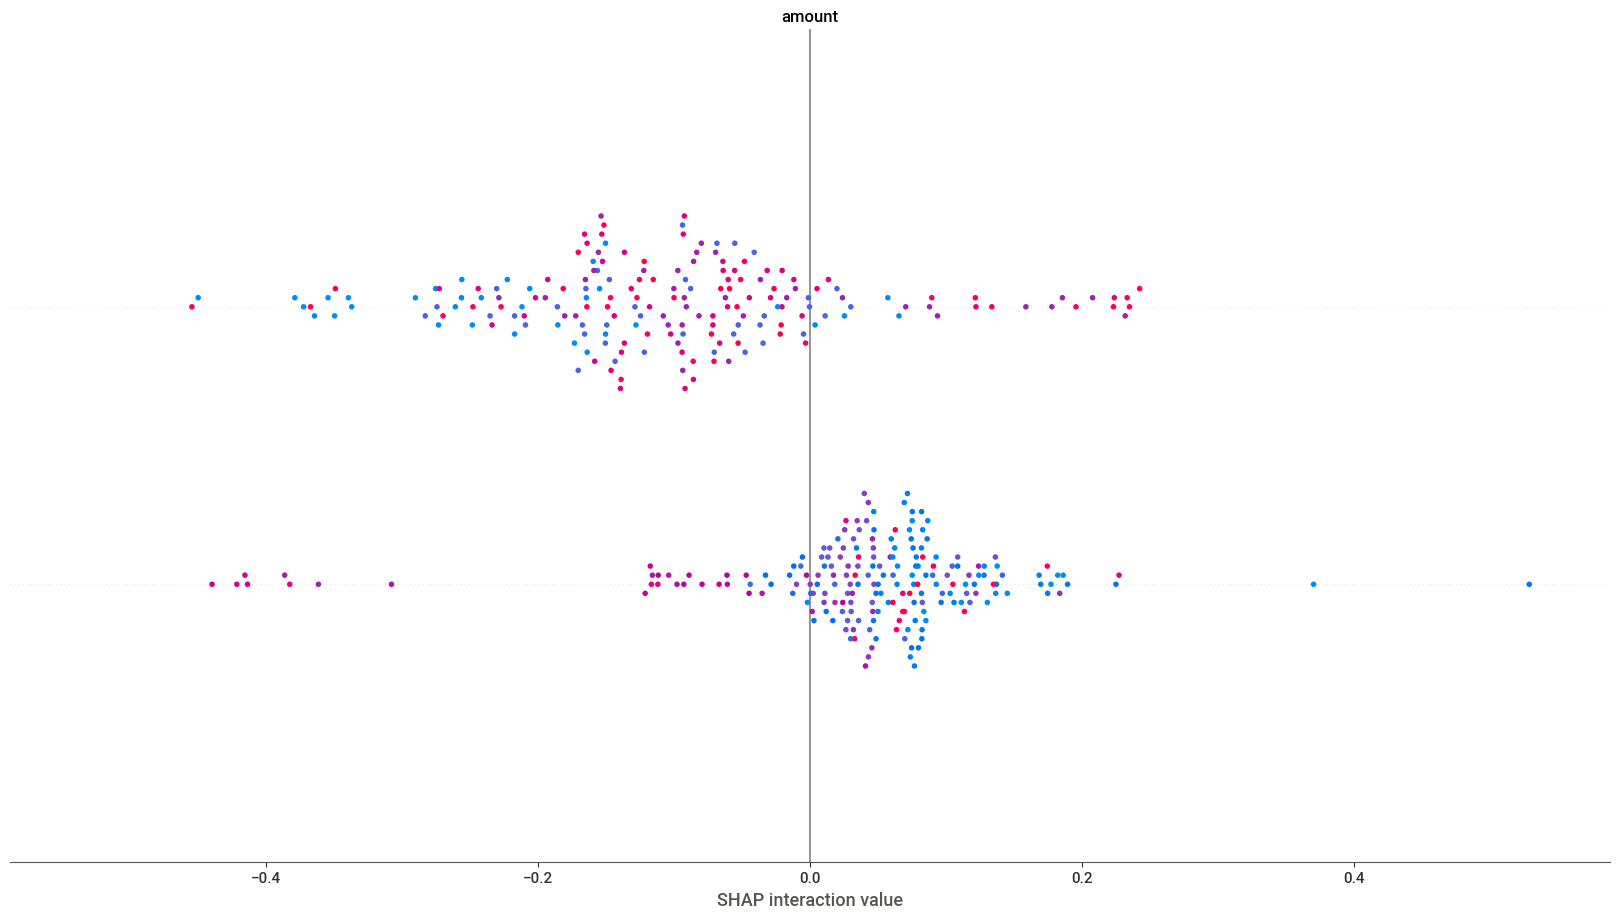



Name of Model:  RandomForest Classifier


              precision    recall  f1-score   support

           0       0.89      1.00      0.94       182
           1       1.00      0.04      0.08        23

    accuracy                           0.89       205
   macro avg       0.95      0.52      0.51       205
weighted avg       0.90      0.89      0.85       205





[[182   0]
 [ 22   1]]


Generating SHAP summary plot


<Figure size 640x480 with 0 Axes>

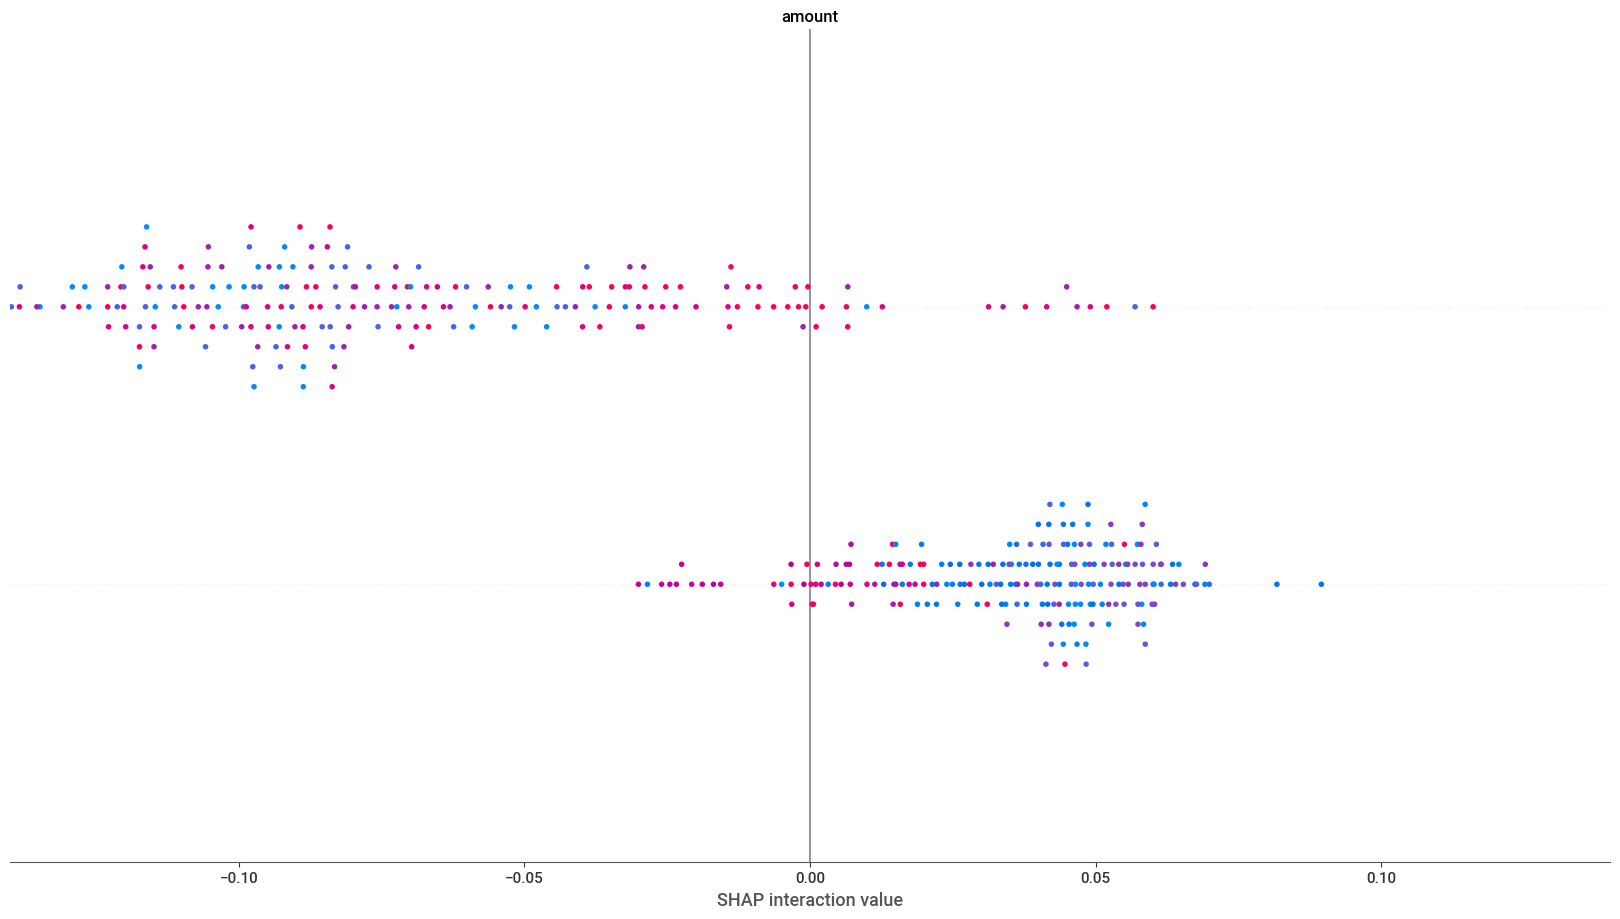

<Figure size 640x480 with 0 Axes>

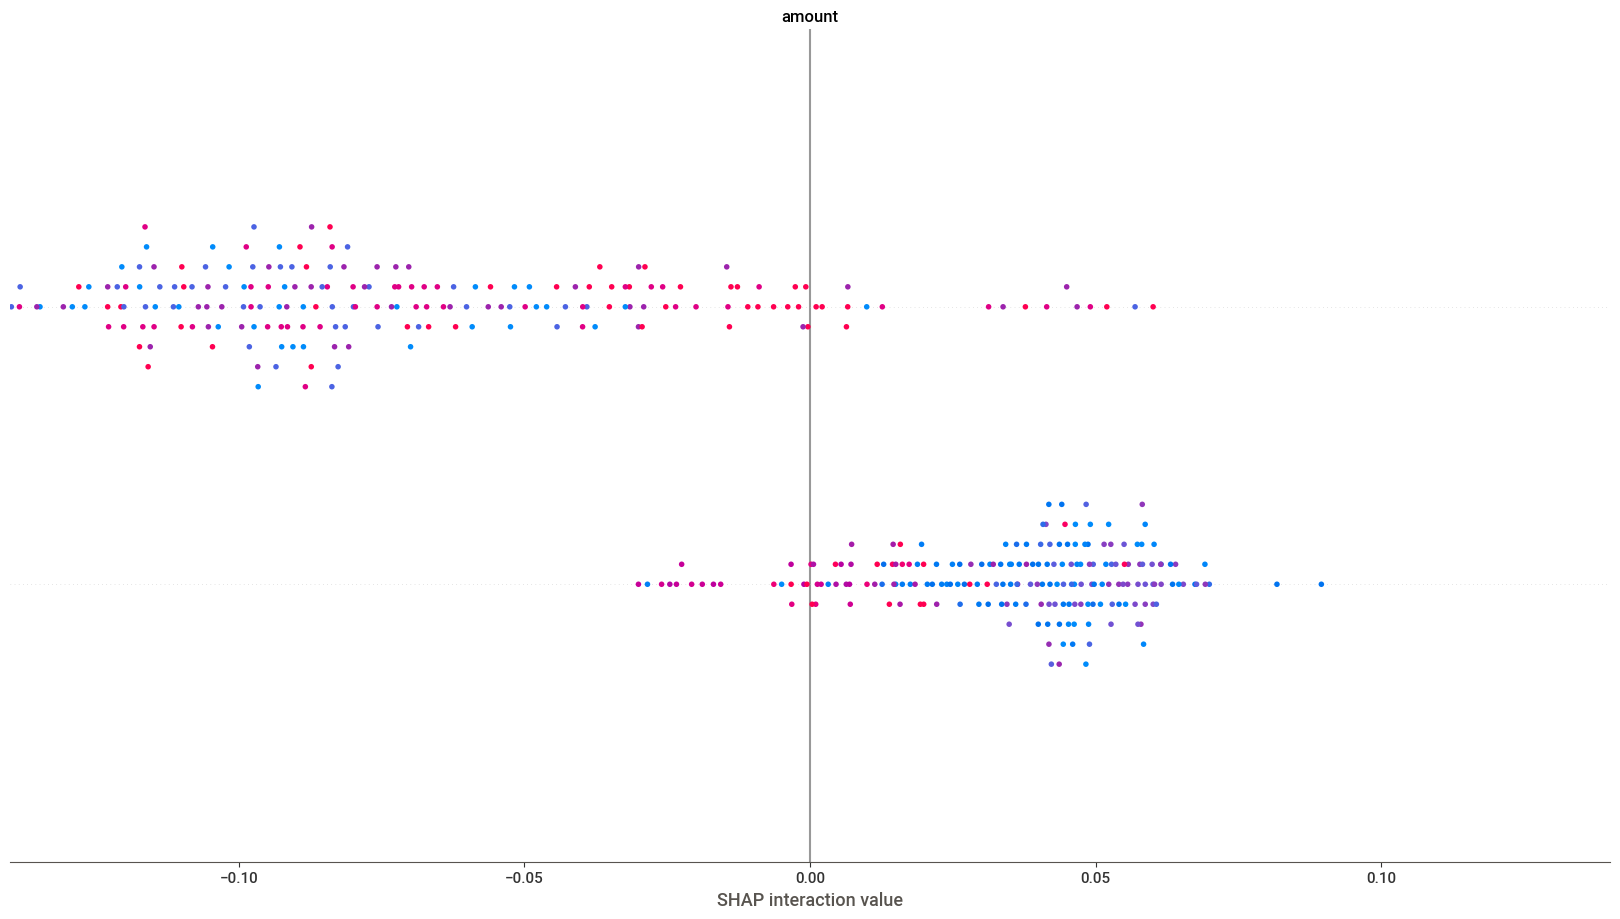

C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(




Name of Model:  AdaBoost Classifier


              precision    recall  f1-score   support

           0       0.88      0.96      0.92       182
           1       0.00      0.00      0.00        23

    accuracy                           0.85       205
   macro avg       0.44      0.48      0.46       205
weighted avg       0.78      0.85      0.82       205





[[175   7]
 [ 23   0]]




Name of Model:  Support Vector Classifier


              precision    recall  f1-score   support

           0       0.93      0.54      0.68       182
           1       0.16      0.70      0.26        23

    accuracy                           0.56       205
   macro avg       0.55      0.62      0.47       205
weighted avg       0.85      0.56      0.64       205





[[98 84]
 [ 7 16]]




Name of Model:  Logistic Regression


              precision    recall  f1-score   support

           0       0.91      0.61      0.73       182
           1       0.14      0.52      0.23        23

  

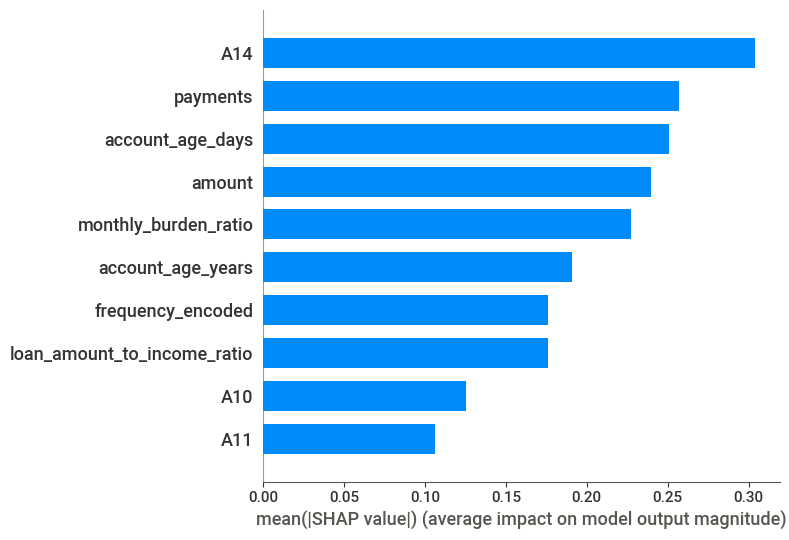

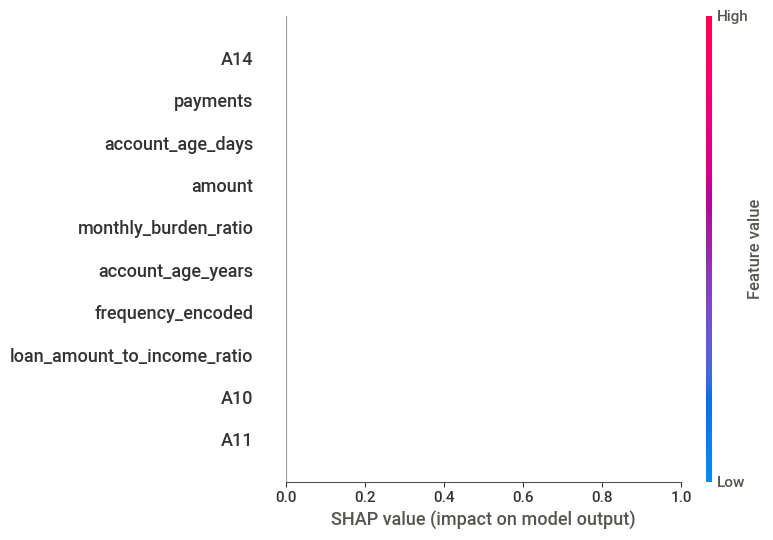



Name of Model:  XGB Classifier


              precision    recall  f1-score   support

           0       0.88      0.93      0.91       182
           1       0.07      0.04      0.05        23

    accuracy                           0.83       205
   macro avg       0.48      0.49      0.48       205
weighted avg       0.79      0.83      0.81       205





[[169  13]
 [ 22   1]]


Generating SHAP summary plot
❌ SHAP failed for XGB Classifier due to: underflow encountered in nextafter


C:\Users\KIIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:20:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [633]:
model_training(models,X_train1,X_test1,y_train1,y_test1)

In [687]:
def model_training_with_smote(models,X_train, X_test, y_train,y_test):
    
    import shap


    X_train_display = pd.DataFrame(X_train, columns=X_train.columns)
    X_test_display = pd.DataFrame(X_test, columns=X_test.columns)

    for i in range(len(models)):
        name = list(models.keys())[i]
        model = list(models.values())[i]
        model.fit(X_train,y_train)
        predictions = model.predict(X_test)
        print("="*35)
        print("\n")
        print("Name of Model: ",name)
        print("\n")
        evaluate_model(y_test,predictions)
        print("="*60)
        print("\n")
        try:
            if name in ['XGB Classifier', 'RandomForest Classifier', 'DecisionTree Classifier', 'CatBoost Classifier']:
                print("Generating SHAP summary plot")
                if 'CatBoost' in name:
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X_test_display)
                elif 'XGB' in name or 'RandomForest' in name or 'DecisionTree' in name:
                    explainer = shap.TreeExplainer(model)
                    shap_values = explainer.shap_values(X_test_display)
                else:
                    explainer = shap.Explainer(model, X_train_display)
                    shap_values = explainer(X_test_display)
                
                shap.summary_plot(shap_values, X_test_display, plot_type='bar', max_display=10)
                shap.summary_plot(shap_values, X_test_display, plot_type='bee swarm', max_display=10)
        
        except Exception as e:
            print(f"❌ SHAP failed for {name} due to: {e}")

            
                
        
            


        
    



Name of Model:  KNeighbors Classifier


              precision    recall  f1-score   support

           0       0.87      0.65      0.74       182
           1       0.09      0.26      0.13        23

    accuracy                           0.60       205
   macro avg       0.48      0.45      0.44       205
weighted avg       0.79      0.60      0.68       205





[[118  64]
 [ 17   6]]




Name of Model:  DecisionTree Classifier


              precision    recall  f1-score   support

           0       0.90      0.86      0.88       182
           1       0.19      0.26      0.22        23

    accuracy                           0.79       205
   macro avg       0.54      0.56      0.55       205
weighted avg       0.82      0.79      0.80       205





[[156  26]
 [ 17   6]]


Generating SHAP summary plot


<Figure size 640x480 with 0 Axes>

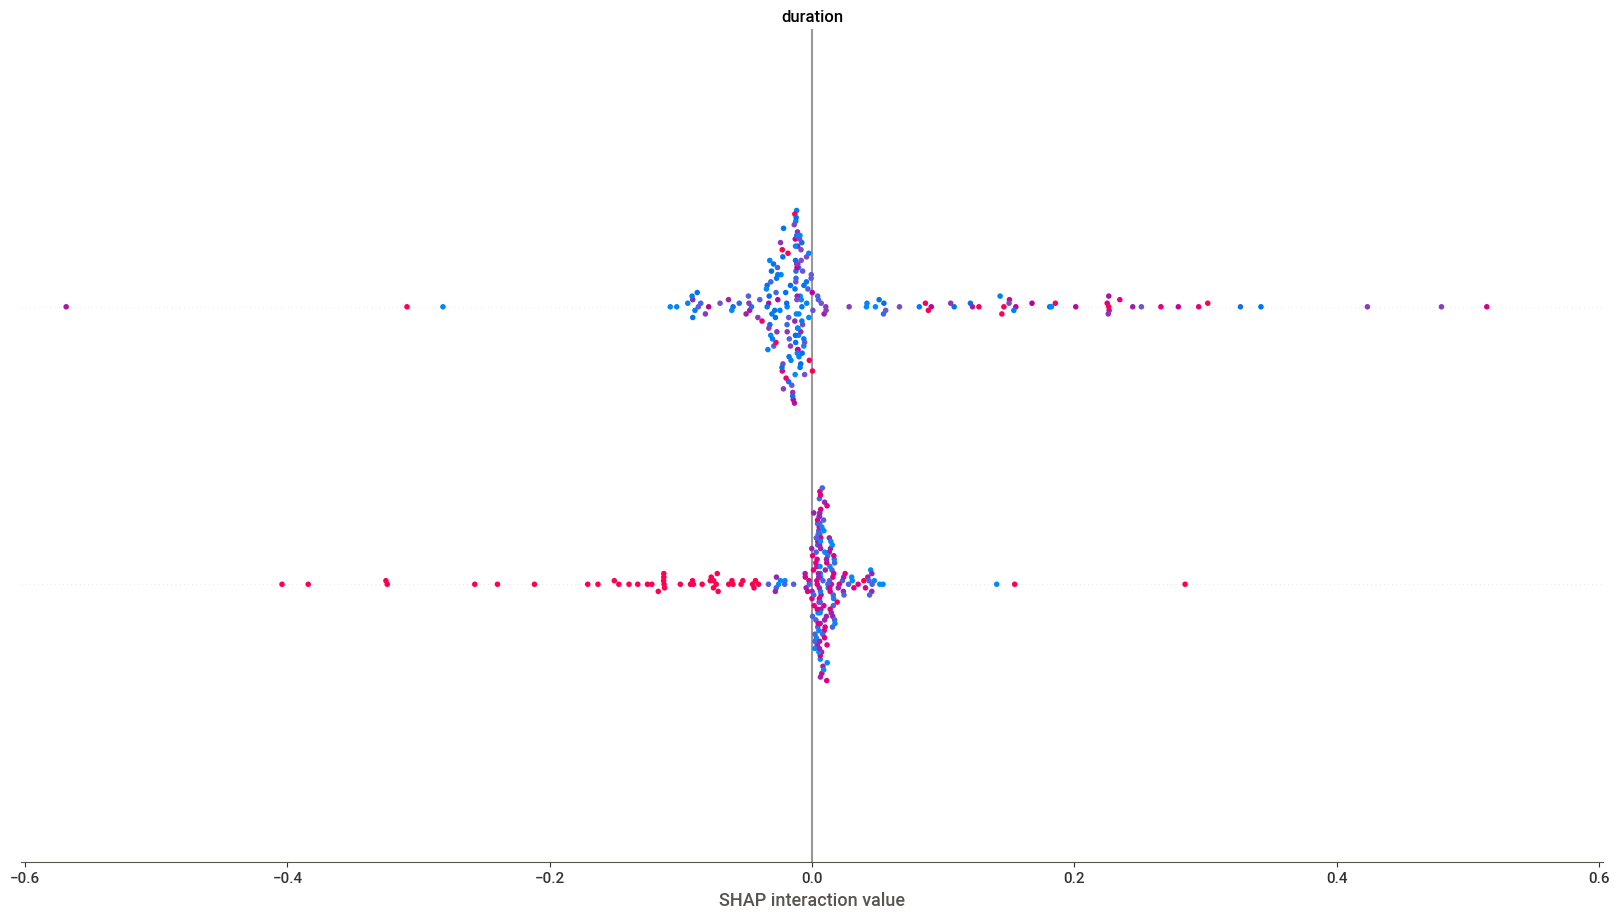

<Figure size 640x480 with 0 Axes>

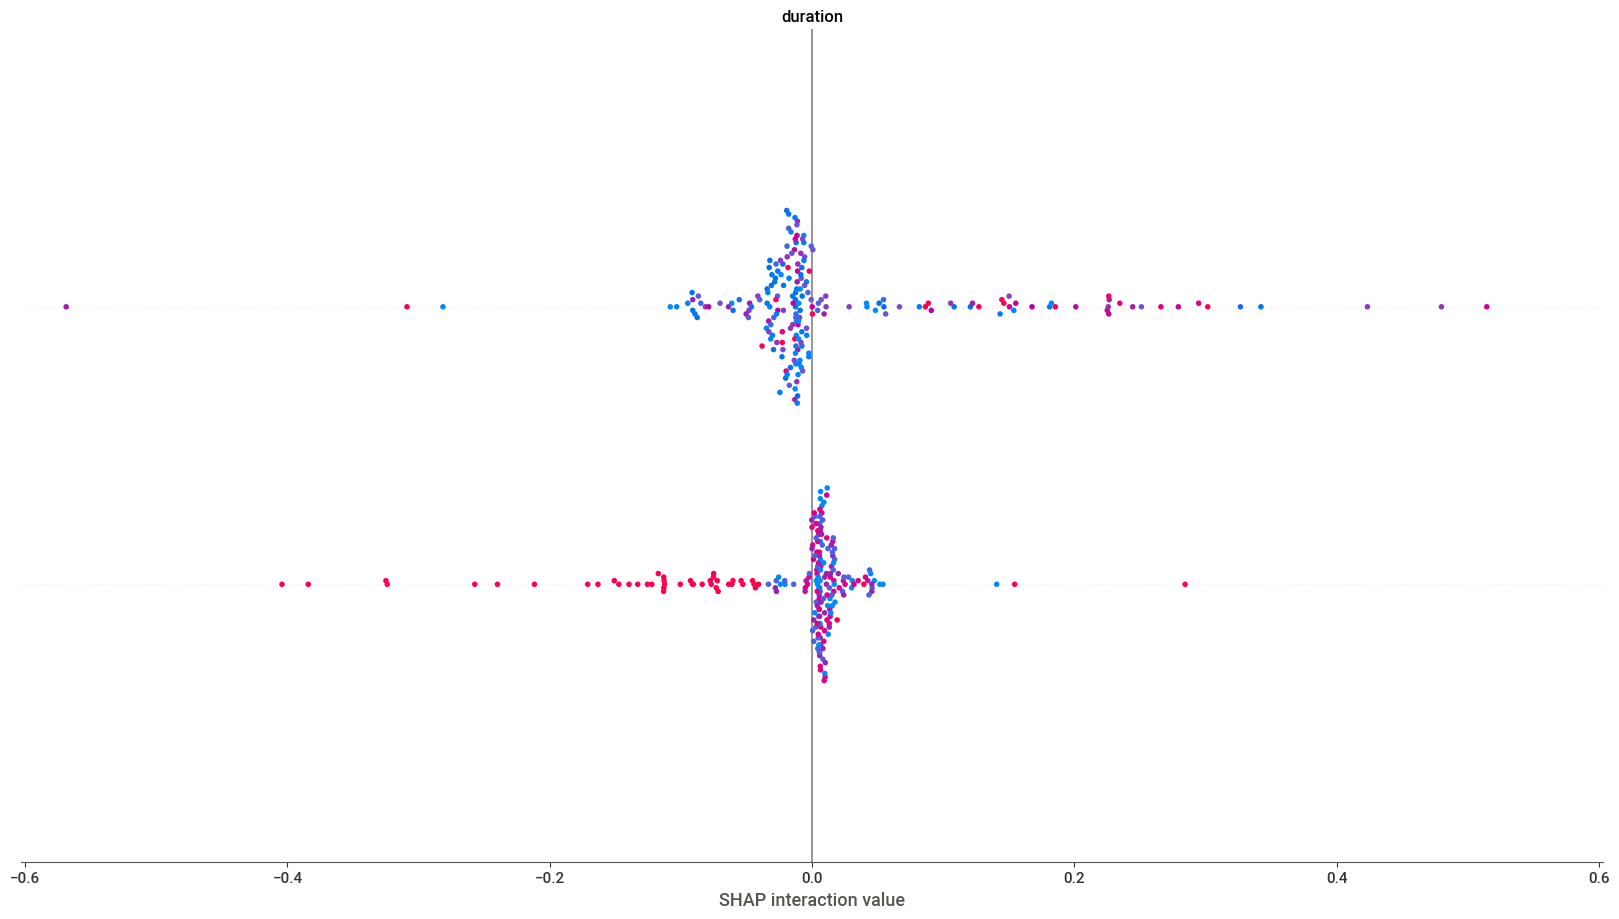



Name of Model:  RandomForest Classifier


              precision    recall  f1-score   support

           0       0.89      0.94      0.91       182
           1       0.08      0.04      0.06        23

    accuracy                           0.84       205
   macro avg       0.48      0.49      0.48       205
weighted avg       0.80      0.84      0.82       205





[[171  11]
 [ 22   1]]


Generating SHAP summary plot


<Figure size 640x480 with 0 Axes>

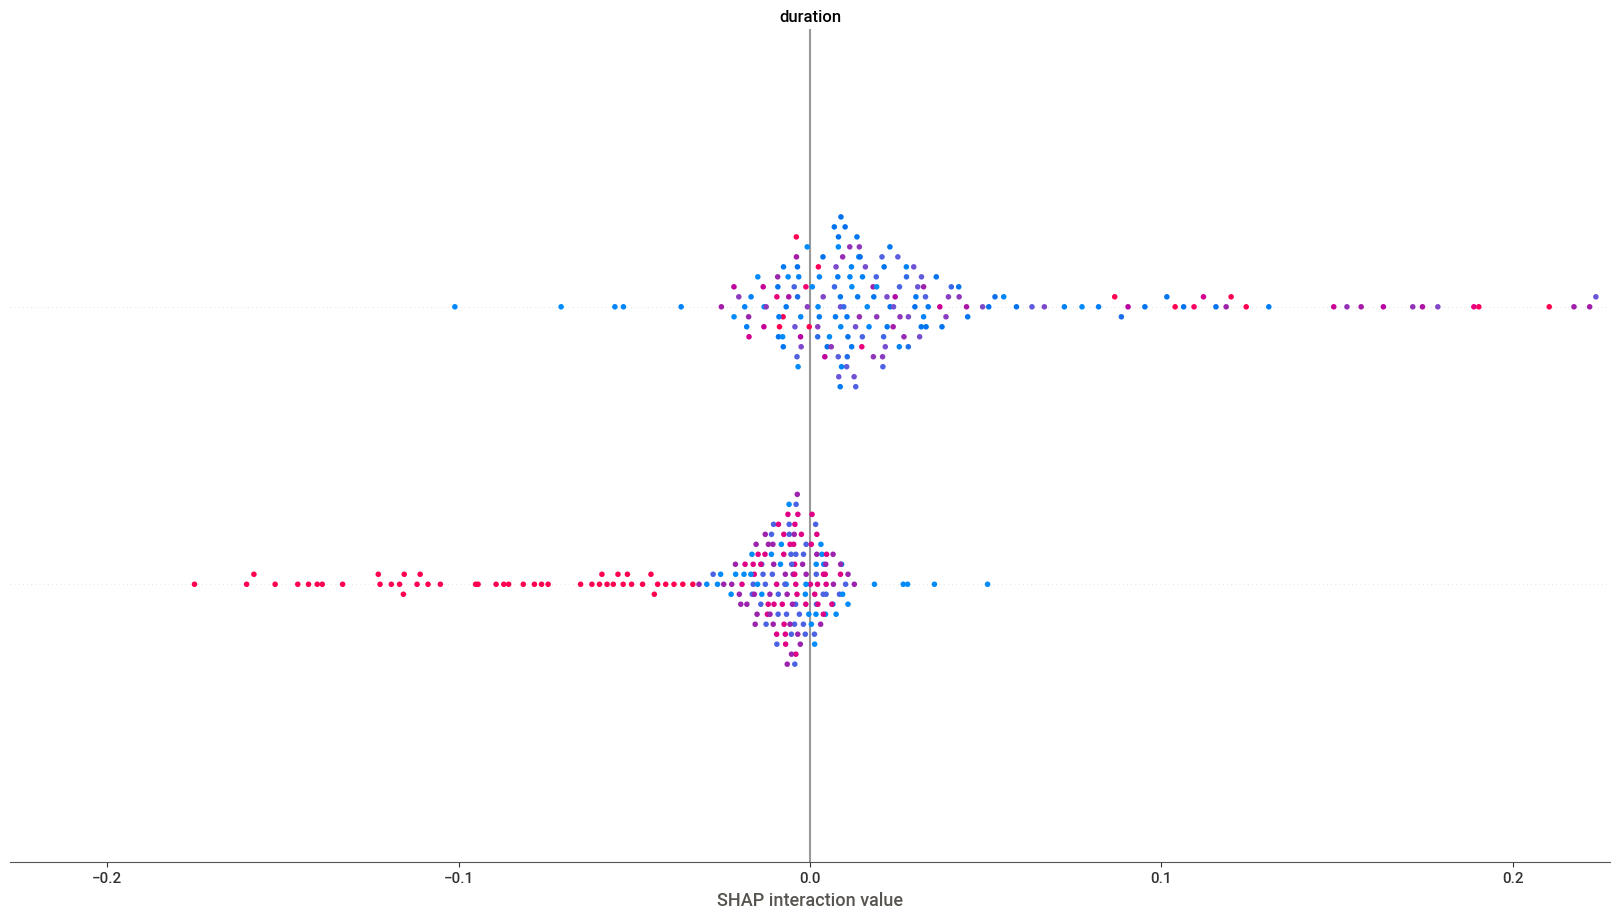

<Figure size 640x480 with 0 Axes>

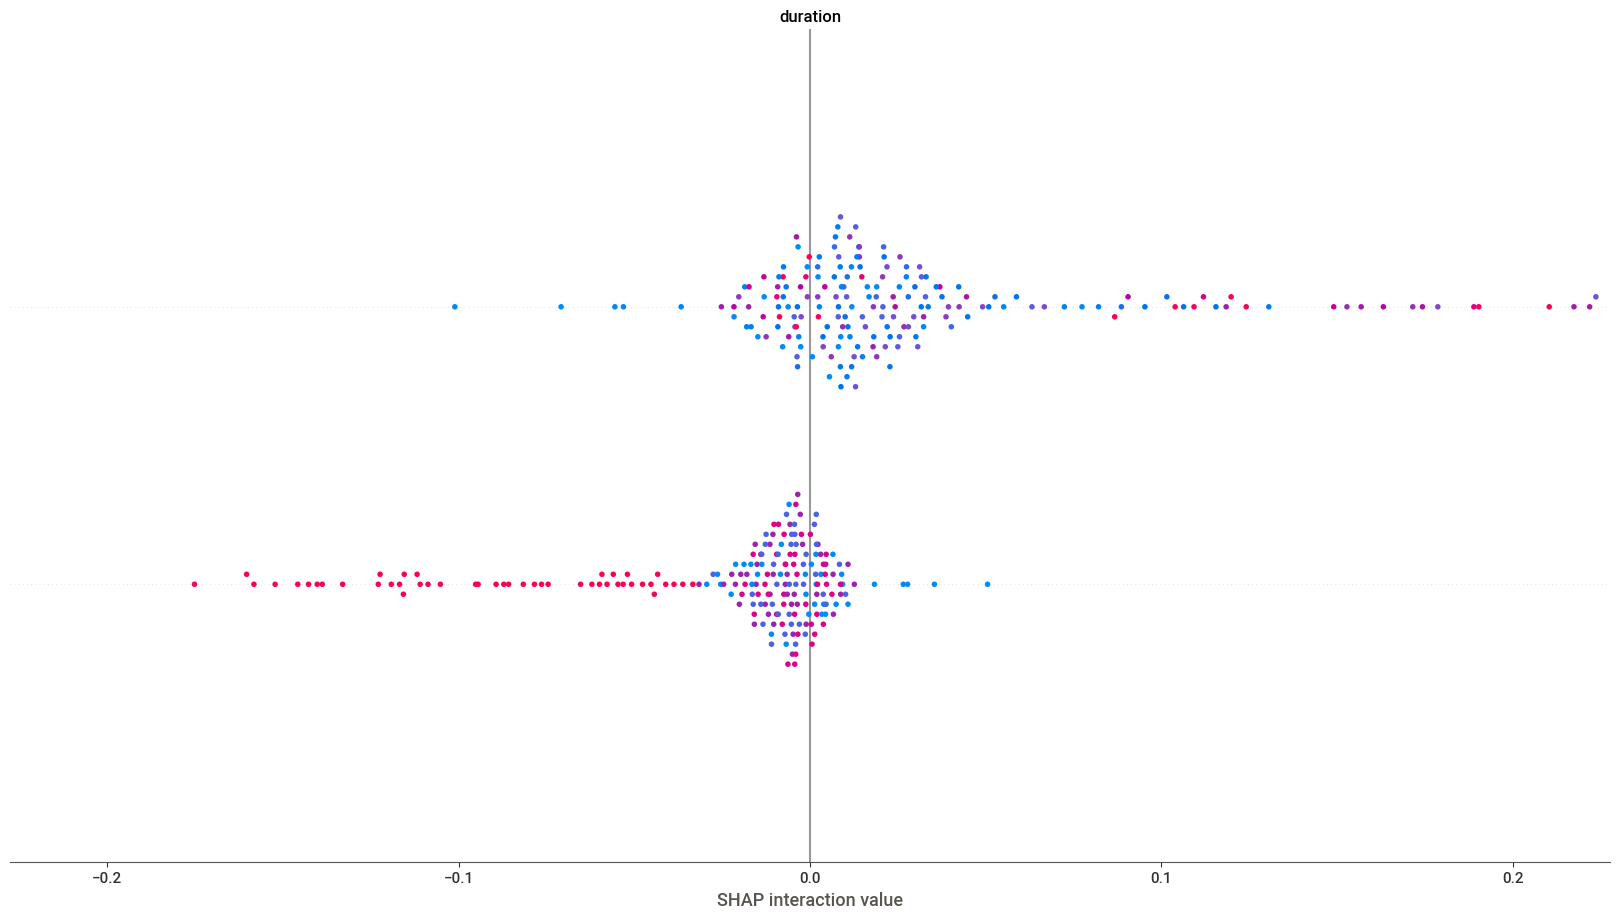

C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(




Name of Model:  AdaBoost Classifier


              precision    recall  f1-score   support

           0       0.89      0.80      0.84       182
           1       0.12      0.22      0.16        23

    accuracy                           0.74       205
   macro avg       0.51      0.51      0.50       205
weighted avg       0.80      0.74      0.77       205





[[146  36]
 [ 18   5]]




Name of Model:  Support Vector Classifier


              precision    recall  f1-score   support

           0       0.92      0.53      0.67       182
           1       0.15      0.65      0.24        23

    accuracy                           0.54       205
   macro avg       0.54      0.59      0.46       205
weighted avg       0.84      0.54      0.62       205





[[96 86]
 [ 8 15]]




Name of Model:  Logistic Regression


              precision    recall  f1-score   support

           0       0.90      0.64      0.75       182
           1       0.13      0.43      0.20        23

  

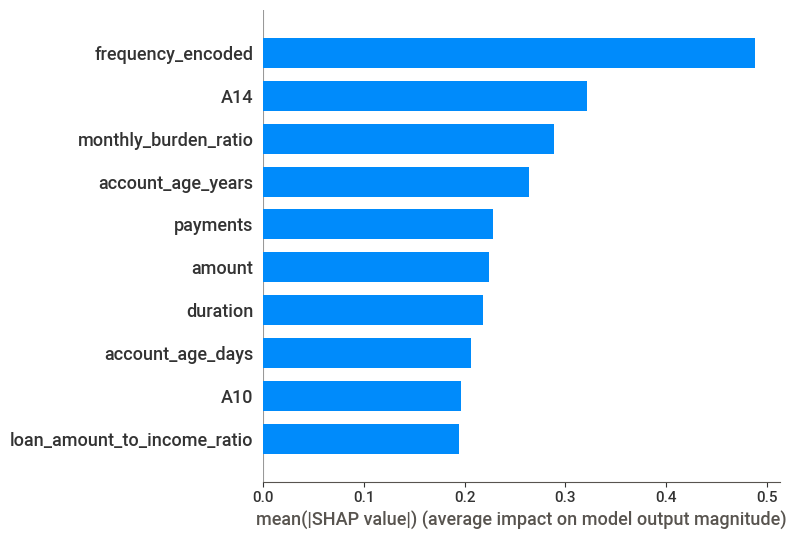

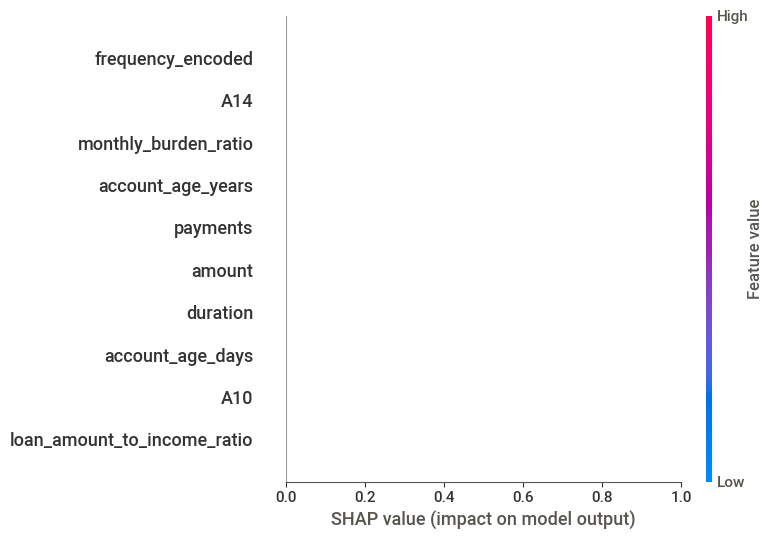



Name of Model:  XGB Classifier


              precision    recall  f1-score   support

           0       0.90      0.91      0.90       182
           1       0.19      0.17      0.18        23

    accuracy                           0.82       205
   macro avg       0.54      0.54      0.54       205
weighted avg       0.82      0.82      0.82       205





[[165  17]
 [ 19   4]]


Generating SHAP summary plot
❌ SHAP failed for XGB Classifier due to: underflow encountered in nextafter


C:\Users\KIIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:15:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [689]:
model_training_with_smote(models,X_train_sm,X_test,y_train_sm,y_test)

In [655]:
assert all(X_train_sm_1.columns == X_test1.columns), "Train and test columns do not match"




Name of Model:  KNeighbors Classifier


              precision    recall  f1-score   support

           0       0.88      0.66      0.75       182
           1       0.09      0.26      0.13        23

    accuracy                           0.61       205
   macro avg       0.48      0.46      0.44       205
weighted avg       0.79      0.61      0.68       205





[[120  62]
 [ 17   6]]




Name of Model:  DecisionTree Classifier


              precision    recall  f1-score   support

           0       0.89      0.87      0.88       182
           1       0.14      0.17      0.16        23

    accuracy                           0.79       205
   macro avg       0.52      0.52      0.52       205
weighted avg       0.81      0.79      0.80       205





[[158  24]
 [ 19   4]]


Generating SHAP summary plot


<Figure size 640x480 with 0 Axes>

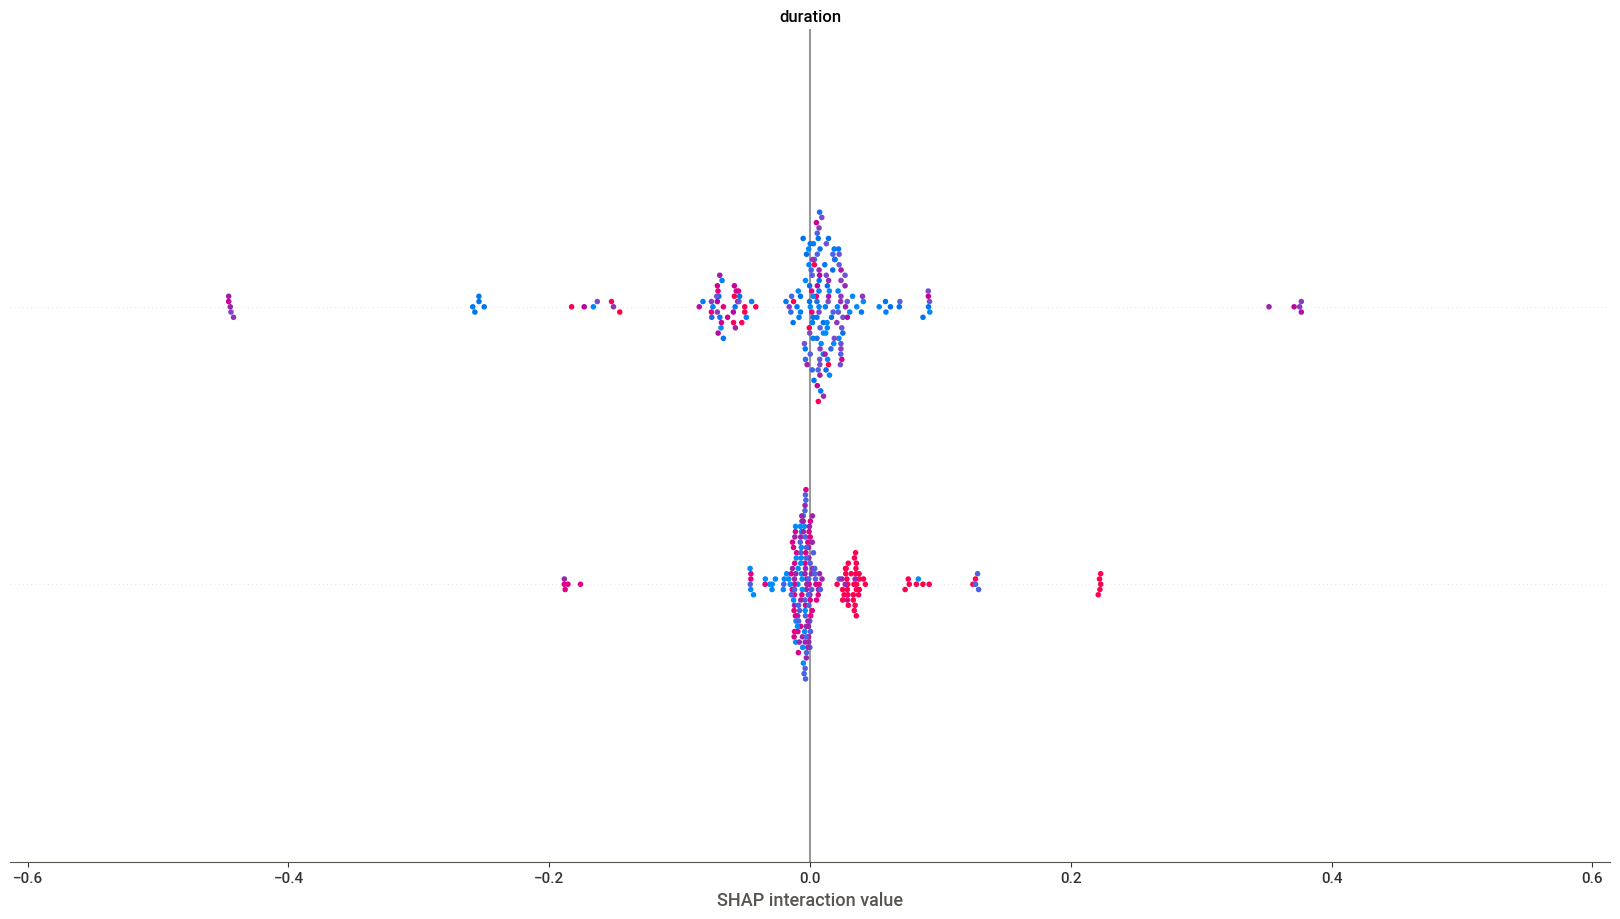

<Figure size 640x480 with 0 Axes>

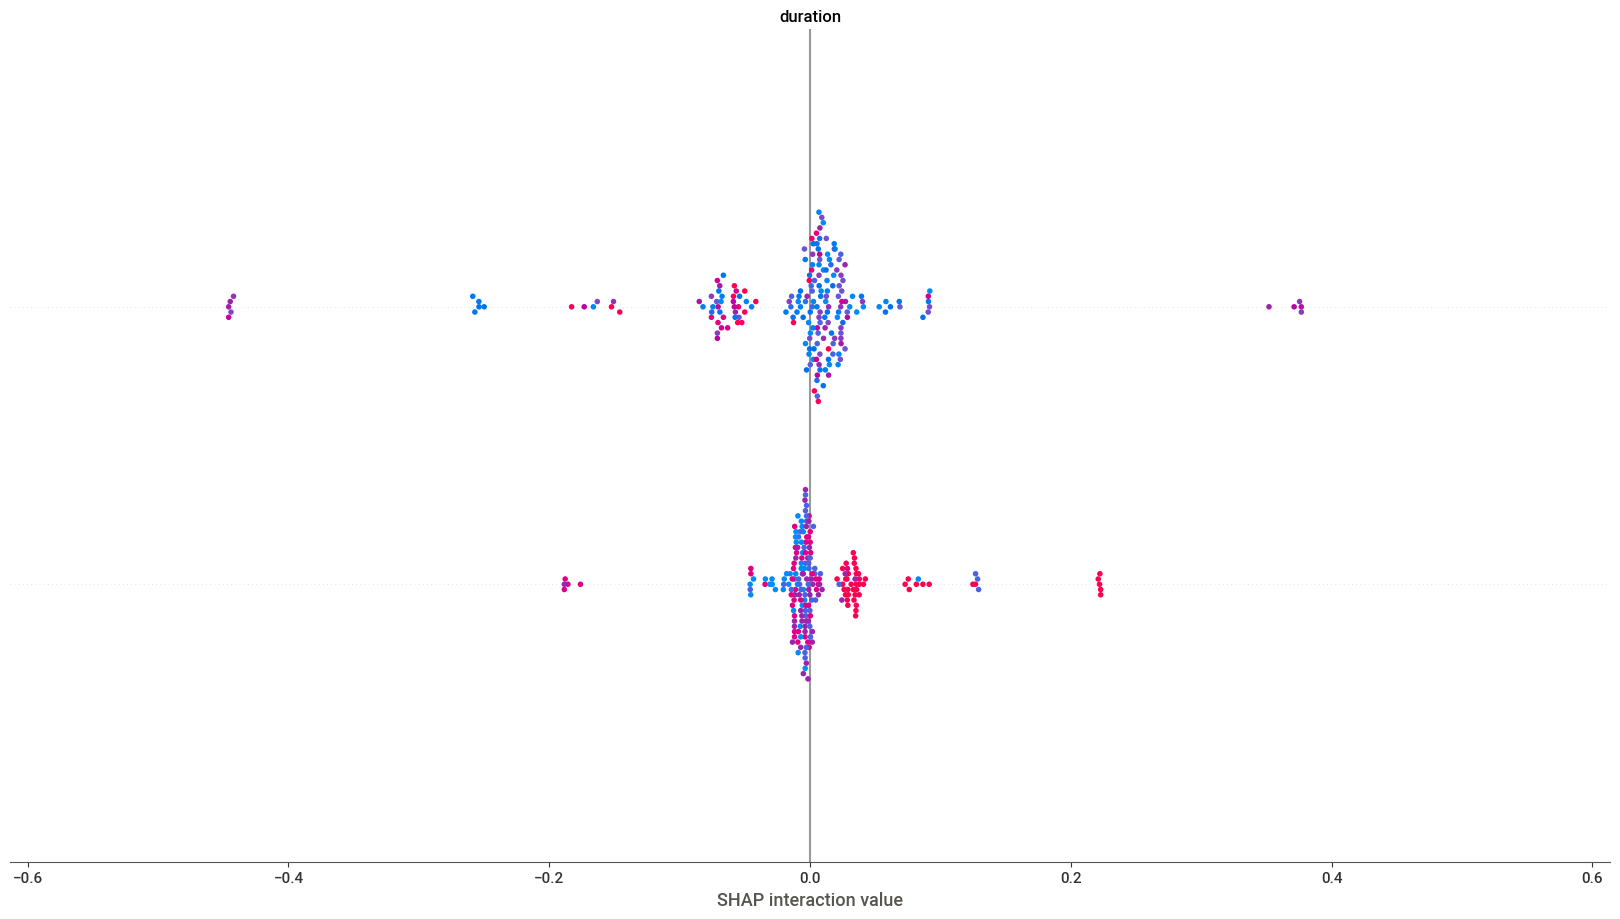



Name of Model:  RandomForest Classifier


              precision    recall  f1-score   support

           0       0.88      0.92      0.90       182
           1       0.07      0.04      0.05        23

    accuracy                           0.82       205
   macro avg       0.48      0.48      0.48       205
weighted avg       0.79      0.82      0.81       205





[[168  14]
 [ 22   1]]


Generating SHAP summary plot


<Figure size 640x480 with 0 Axes>

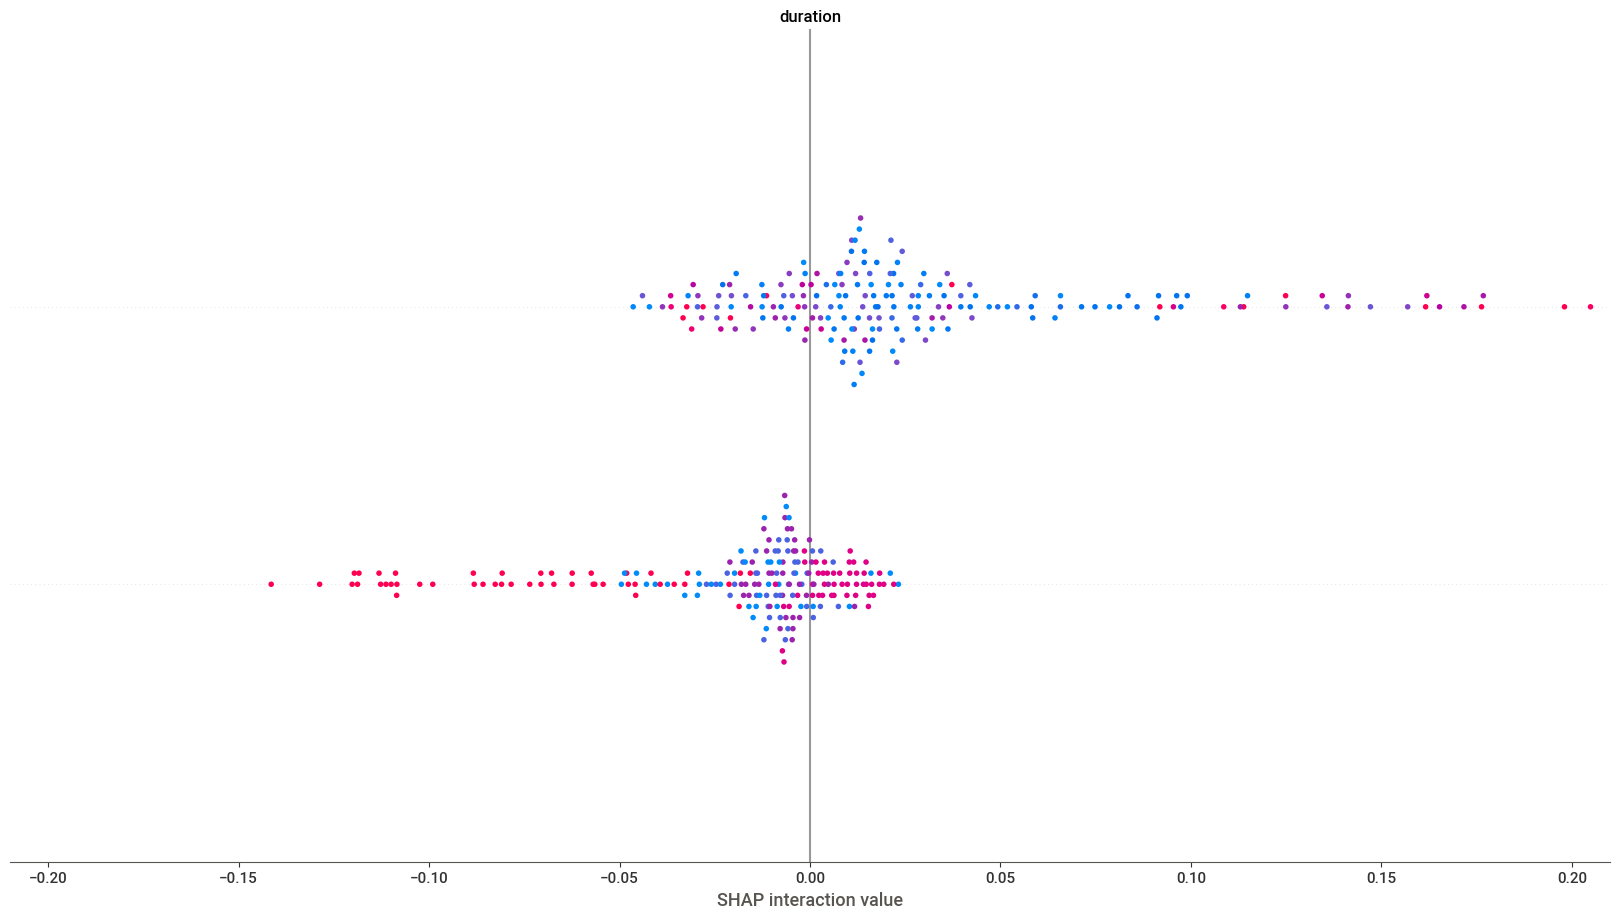

<Figure size 640x480 with 0 Axes>

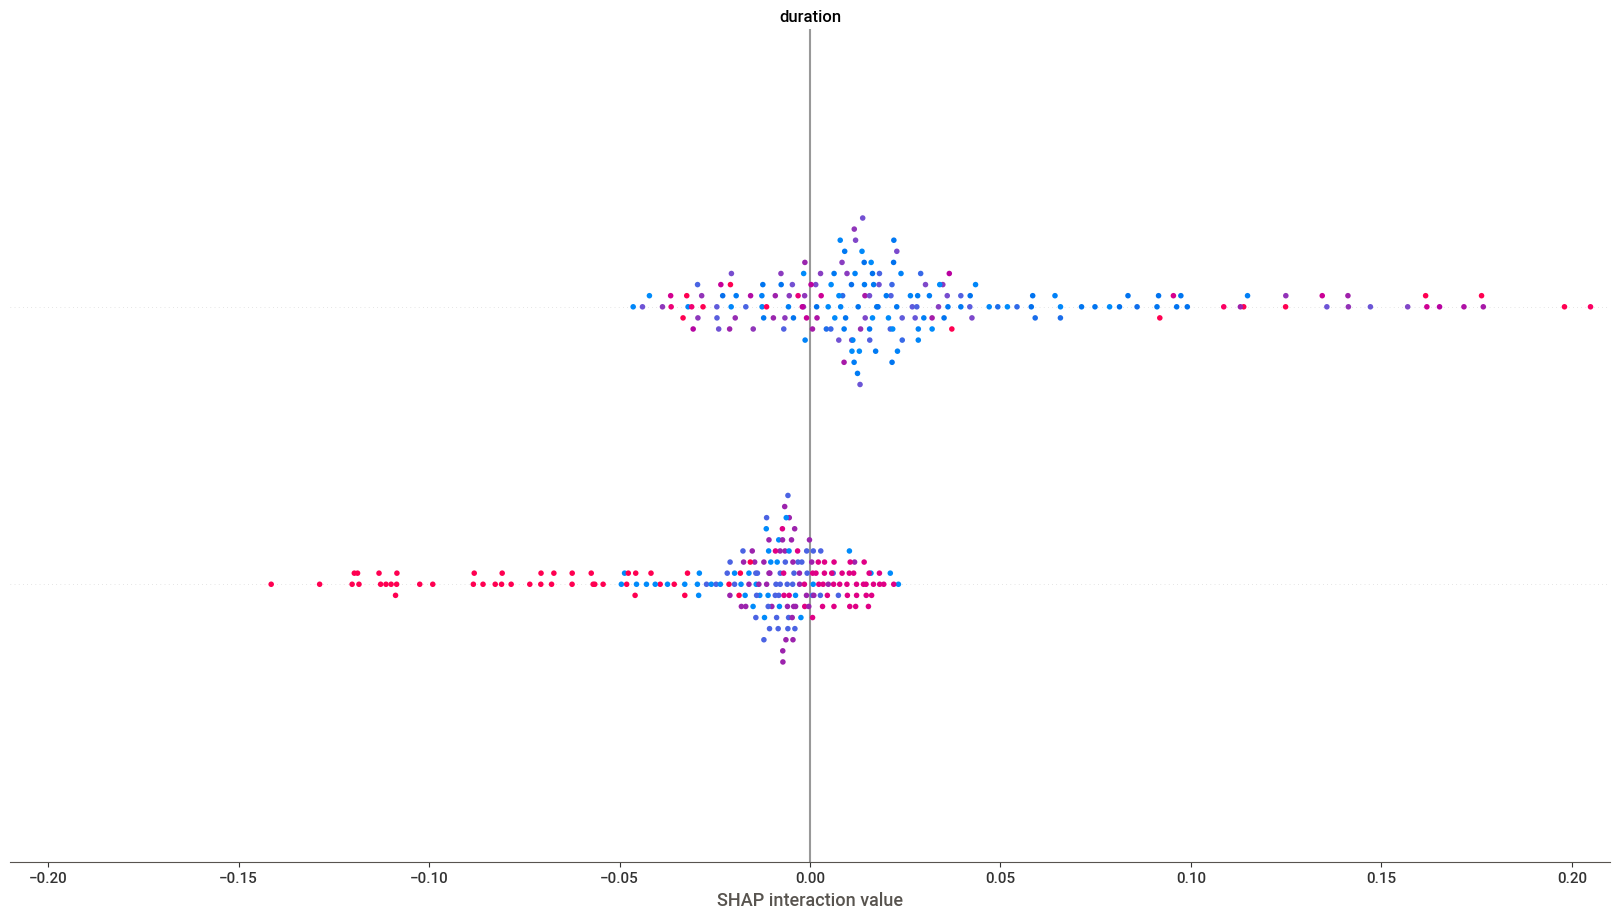

C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(




Name of Model:  AdaBoost Classifier


              precision    recall  f1-score   support

           0       0.90      0.83      0.86       182
           1       0.16      0.26      0.20        23

    accuracy                           0.77       205
   macro avg       0.53      0.55      0.53       205
weighted avg       0.82      0.77      0.79       205





[[151  31]
 [ 17   6]]




Name of Model:  Support Vector Classifier


              precision    recall  f1-score   support

           0       0.92      0.53      0.67       182
           1       0.15      0.65      0.24        23

    accuracy                           0.54       205
   macro avg       0.54      0.59      0.46       205
weighted avg       0.84      0.54      0.62       205





[[96 86]
 [ 8 15]]




Name of Model:  Logistic Regression


              precision    recall  f1-score   support

           0       0.89      0.65      0.75       182
           1       0.11      0.35      0.17        23

  

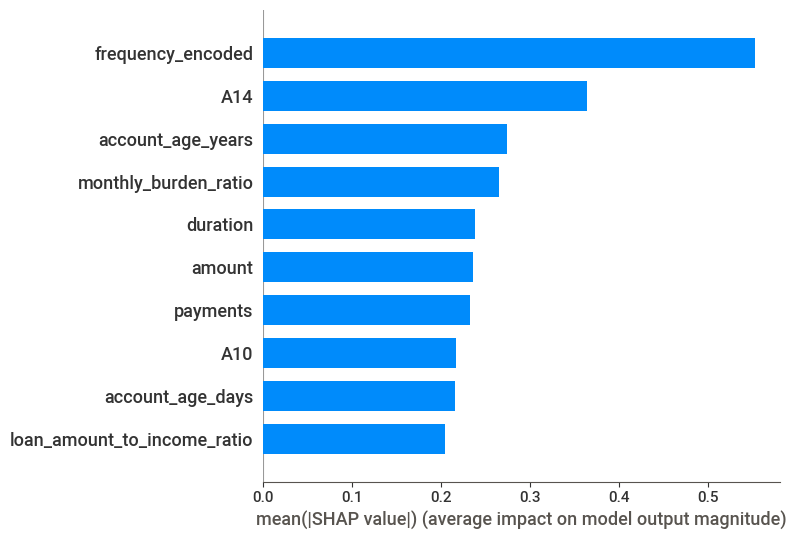

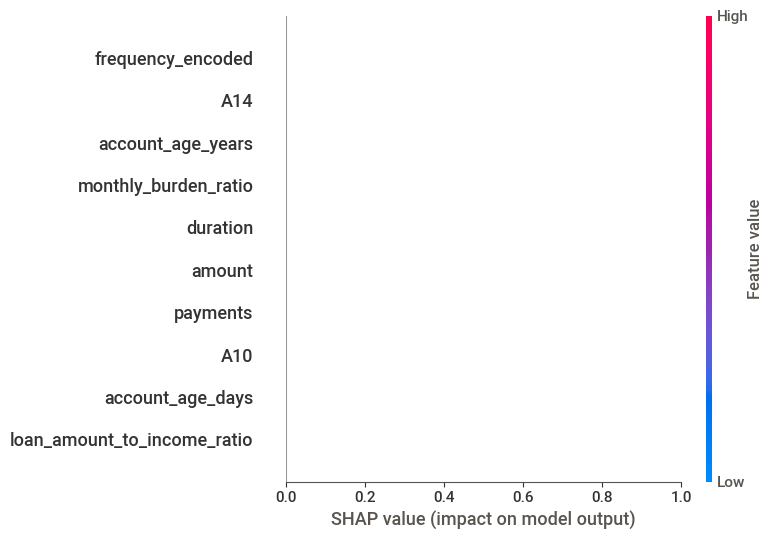



Name of Model:  XGB Classifier


              precision    recall  f1-score   support

           0       0.89      0.87      0.88       182
           1       0.14      0.17      0.16        23

    accuracy                           0.79       205
   macro avg       0.52      0.52      0.52       205
weighted avg       0.81      0.79      0.80       205





[[158  24]
 [ 19   4]]


Generating SHAP summary plot
❌ SHAP failed for XGB Classifier due to: underflow encountered in nextafter


C:\Users\KIIT\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:16:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [691]:
model_training_with_smote(models,X_train_sm_1,X_test1,y_train_sm_1,y_test1)

In [220]:
def final_model_grid(X_train,X_test,y_train,y_test):

    model = SVC(probability=True,class_weight='balanced', random_state=42,C =1 , gamma='scale', kernel='rbf')
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))
    

In [222]:
final_model_grid(X_train,X_test,y_train,y_test)

              precision    recall  f1-score   support

           0       0.93      0.53      0.67       182
           1       0.16      0.70      0.26        23

    accuracy                           0.55       205
   macro avg       0.54      0.61      0.46       205
weighted avg       0.85      0.55      0.63       205

